# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

import sklearn.model_selection
from numpy.core.umath_tests import inner1d

from scipy.stats import randint as sp_randint

/Users/marialaraa/.virtualenvs/aa/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Carga de datos
X = pd.read_csv("../TP1/X.csv", index_col="index")
y = pd.read_csv("../TP1/y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("../TP1/X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("../TP1/y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)
X.describe()

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

0       1       2       3       4       5       6   ...       193  \
index                                                           ...             
0      1.4914  0.1644  1.2315  1.2429  1.5576  0.0455  0.1302   ...   -1.1983   
1     -0.2749  0.2780 -1.3108  0.6801 -0.5503  0.6359 -0.4478   ...    1.2190   
2     -0.2243 -0.5710 -0.2712 -0.1328 -1.0045  0.9315 -1.4507   ...    0.9459   
3      0.5853 -0.8532 -0.2723 -0.5493 -2.9824 -0.1697 -0.0430   ...    1.6488   
4     -1.4155  1.4187  0.6027 -0.7993  0.2939 -0.1796 -0.7140   ...    1.1314   
...       ...     ...     ...     ...     ...     ...     ...   ...       ...   
495    0.2516  0.9375 -1.1980  0.4577  0.9287  0.5373  0.2476   ...    0.5829   
496    0.6246 -1.0590  0.9491  0.2687  0.6610 -1.6657  0.3982   ...   -0.1075   
497    0.2677  0.1802  0.7154  0.3542 -0.9023 -1.7792 -0.0121   ...    0.8491   
498    0.1926  0.7834  1.7056  0.3418 -0.8350  0.4068  0.0495   ...   -0.0130   
499    0.0427  0.4028 -0.6085  1.0845  0.1033  0.2698 -0.8598   ...   -0.3587   

          194     195     196     197     198     199  
index                                                  
0     -0.0118  1.5375 -0.7727 -0.1401  2.0871 -0.8312  
1     -0.3190 -0.6446 -0.0061 -1.2374 -1.3291 -1.3265  
2      0.1430 -0.1989 -0.0393 -0.5866  2.2507  1.4925  
3     -0.7363 -0.8866 -1.2717 -0.1493  0.2007 -1.4820  
4     -0.4230 -0.2685  0.3045 -1.2245 -1.9421  1.5186  
...       ...     ...     ...     ...     ...     ...  
495   -0.5494  0.4607  1.2182  0.1025  3.0034 -0.0344  
496    0.8993 -0.4229  0.3977 -0.0808 -1.7054 -0.4786  
497    0.7469  0.2071 -1.0090  0.3317 -1.7513 -0.5397  
498    0.1483  0.5019 -0.0020 -1.6642  2.5117 -0.0118  
499   -0.3121 -0.7630  0.6525  0.6161 -0.0902 -1.0215  

[500 rows x 200 columns]

output
index        
0           0
1           0
2           0
3           0
4           1
...       ...
495         1
496         0
497         1
498         0
499         0

[500 rows x 1 columns]

0         1         2         3         4         5         6  \
count  500.0000  500.0000  500.0000  500.0000  500.0000  500.0000  500.0000   
mean     0.0384    0.0715    0.0056   -0.0103   -0.0436   -0.0208   -0.0571   
std      1.0153    0.9613    1.0360    1.0230    1.0647    0.9898    1.0000   
min     -3.1722   -2.4596   -2.8834   -3.7474   -2.9987   -3.2014   -3.6855   
25%     -0.6090   -0.6207   -0.7180   -0.6594   -0.7177   -0.6510   -0.7073   
50%      0.0602    0.0560   -0.0713    0.0612   -0.0097   -0.0407   -0.0771   
75%      0.6334    0.7670    0.7066    0.6699    0.6616    0.6508    0.6029   
max      2.9702    2.7920    2.6905    2.8091    2.9823    2.9342    3.3240   

         ...          193       194       195       196       197       198  \
count    ...     500.0000  500.0000  500.0000  500.0000  500.0000  500.0000   
mean     ...      -0.0187    0.0087   -0.0356   -0.1940    0.0250    0.0257   
std      ...       0.9731    0.9716    1.0075    1.0246    0.9934    0.9940   
min      ...      -2.9110   -2.9642   -2.5163   -3.9278   -2.4254   -2.6234   
25%      ...      -0.6441   -0.6509   -0.6613   -0.8689   -0.6466   -0.6354   
50%      ...      -0.0473    0.0537   -0.0749   -0.1901    0.0185   -0.0332   
75%      ...       0.6071    0.6860    0.5743    0.4636    0.7041    0.6575   
max      ...       3.0983    3.1469    2.9109    2.4942    3.1804    3.0034   

            199  
count  500.0000  
mean    -0.0036  
std      0.9819  
min     -2.8690  
25%     -0.6855  
50%     -0.0797  
75%      0.6608  
max      2.5107  

[8 rows x 200 columns]

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

Del total de los datos nos quedamos con un 0.2% como held out que no será utilizado a lo largo del trabajo práctico. La distribución de los datos fue testeada en ambos grupos para que fuese equivalente. 

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación


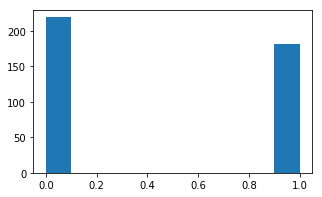

In [3]:
# EJERCICIO 1. 

np.random.seed(SEED)

########################################################
import sklearn.model_selection

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, random_state=SEED, test_size=0.2)

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

Accuracy (training)  Accuracy (validación)  AUC ROC (training)  \
Permutación                                                                   
1                         0.8031                 0.5875              0.8135   
2                         0.8500                 0.6250              0.8505   
3                         0.8187                 0.6125              0.8247   
4                         0.8281                 0.7375              0.8198   
5                         0.8094                 0.5750              0.7845   

             AUC ROC (validación)  
Permutación                        
1                          0.5984  
2                          0.6202  
3                          0.6132  
4                          0.7238  
5                          0.5816

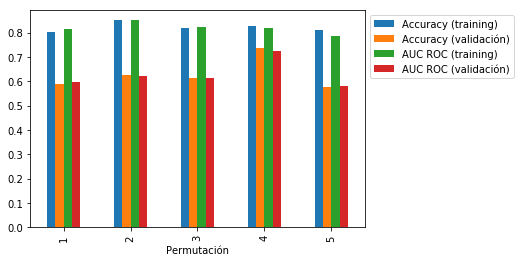

In [4]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score


kf = KFold(n_splits=5)

accuracy_train = []
accuracy_eval = []
AUCROC_train = []
AUCROC_eval = []

for dev_index, eval_index in kf.split(X_dev_np):
    X_dev_folds = X_dev_np[dev_index]
    X_eval_folds = X_dev_np[eval_index]
    y_dev_folds, y_eval_folds = y_dev_np[dev_index], y_dev_np[eval_index]
    
    tree = DecisionTreeClassifier(max_depth=3)
    tree.fit(X_dev_folds, y_dev_folds)
    
    prediction_dev = tree.predict(X_dev_folds)
    prediction_eval = tree.predict(X_eval_folds)
    
    accuracy_train.append(accuracy_score(y_dev_folds, prediction_dev))
    accuracy_eval.append(accuracy_score(y_eval_folds, prediction_eval))
    AUCROC_train.append(roc_auc_score(y_dev_folds, prediction_dev))
    AUCROC_eval.append(roc_auc_score(y_eval_folds, prediction_eval))
    
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracy_train    # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracy_eval   # cambiar por accuracies_validation
df["AUC ROC (training)"] = AUCROC_train      # cambiar por aucs_training
df["AUC ROC (validación)"] = AUCROC_eval    # cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Dividimos el X_dev definido inicialmente en train y test para el entrenamiento de los próximos modelos. 

In [5]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev, y_dev, random_state=SEED, test_size=0.2)


X_train_np = np.array(X_train)
y_train_np = np.array(y_train).ravel()
X_test_np = np.array(X_test)
y_test_np = np.array(y_test).ravel()

In [6]:
resultados_training = []
resultados_validation = []

########################################################
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        tree = DecisionTreeClassifier(max_depth=altura, criterion=criterio, random_state=SEED)
        tree.fit(X_train, y_train)
        
        prediction_dev = tree.predict(X_train)
        prediction_eval = tree.predict(X_test)
        
        resultados_training.append(roc_auc_score(y_train, prediction_dev))
        resultados_validation.append(roc_auc_score(y_test, prediction_eval))

## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
# np.random.seed(SEED)
# for criterio in ["gini", "entropy"]:
#     for altura in [3, 5, None]:
#         CODIGO AQUI.
#         resultados_training.append( <RESULTADO_TRAINING> )
#         resultados_validation.append( <RESULTADO_VALIDATION> )
#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training # reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

Altura máxima Criterio de evaluación de corte  AUC ROC promedio (training)  \
0             3                            Gini                       0.8414   
1             5                            Gini                       0.9480   
2     Inifinito                            Gini                       1.0000   
3             3         Ganancia de Información                       0.7993   
4             5         Ganancia de Información                       0.9275   
5     Inifinito         Ganancia de Información                       1.0000   

   AUC ROC promedio (validación)  
0                         0.6927  
1                         0.6823  
2                         0.6562  
3                         0.6562  
4                         0.6354  
5                         0.6250

            0       1       2       3       4       5       6   ...       193  \
index                                                           ...             
0      1.4914  0.1644  1.2315  1.2429  1.5576  0.0455  0.1302   ...   -1.1983   
1     -0.2749  0.2780 -1.3108  0.6801 -0.5503  0.6359 -0.4478   ...    1.2190   
2     -0.2243 -0.5710 -0.2712 -0.1328 -1.0045  0.9315 -1.4507   ...    0.9459   
3      0.5853 -0.8532 -0.2723 -0.5493 -2.9824 -0.1697 -0.0430   ...    1.6488   
4     -1.4155  1.4187  0.6027 -0.7993  0.2939 -0.1796 -0.7140   ...    1.1314   
...       ...     ...     ...     ...     ...     ...     ...   ...       ...   
495    0.2516  0.9375 -1.1980  0.4577  0.9287  0.5373  0.2476   ...    0.5829   
496    0.6246 -1.0590  0.9491  0.2687  0.6610 -1.6657  0.3982   ...   -0.1075   
497    0.2677  0.1802  0.7154  0.3542 -0.9023 -1.7792 -0.0121   ...    0.8491   
498    0.1926  0.7834  1.7056  0.3418 -0.8350  0.4068  0.0495   ...   -0.0130   
499    0.0427  0.4028 -0.608

/Users/marialaraa/.virtualenvs/aa/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/marialaraa/.virtualenvs/aa/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[-0.3489 -0.396   0.5182  0.6063  0.4214  0.2295 -1.0464 -1.6051  0.5459
  0.4054  0.0661 -1.8365  0.7908 -0.0145  0.2032 -0.3107  1.7865  0.3869
 -0.6699  0.7594  0.6054  1.7159  0.2199  1.4717  2.1469 -0.0067  0.5037
  0.172   0.7218 -0.4413  1.4702  0.1497 -0.1195 -0.9582 -0.5573  0.3655
  1.7484  0.9239 -0.

[ 0.2653  0.6638 -0.8762  1.4978 -1.4934 -0.224   0.8569 -1.0932  0.4882
 -0.0692 -0.3711  1.2401 -1.0653  0.3341 -0.7551 -1.434  -0.0269  1.085
 -0.0295  0.6135  0.352  -0.6469  1.1431 -1.3496  2.1505 -1.6277 -0.6758
 -0.8856 -0.5629  0.0372 -1.1697 -0.7046  0.7344 -0.1925 -0.4054 -0.7377
 -0.696  -1.2187  1.2891 -0.6047 -0.7477 -0.4671 -0.3639 -0.6017 -1.8471
 -0.3543 -0.6015  0.7347 -1.5254 -0.5818  0.1837  1.0622  0.294  -0.2634
 -0.0644  0.2597 -1.0736 -0.4936  0.8515 -1.4655  1.0535  0.2581 -0.3844
 -0.2163 -0.304   0.4444 -0.1578 -0.2577 -0.9936 -0.2231 -1.7352 -2.1223
 -0.4597 -2.3395  0.6499  0.9742  0.7571 -0.5548 -1.3491  1.041   0.33
 -0.9115  1.3171  0.808  -2.0709 -1.8569 -0.1284 -0.5547 -0.9804  0.2378
  0.6546  0.7503 -0.0799  0.1118 -0.0593  0.1499 -1.2009  0.0063 -1.5626
 -0.4745  0.8474 -0.2875 -1.6828 -0.9468 -0.5846 -0.6434 -0.7172  1.5546
 -0.9557  1.4855 -0.4628  0.1099 -0.1749  0.2132  0.9289  0.0518  1.1427
  0.9416 -0.9168 -0.6302  0.8427 -1.4362 -0.6419 -1.09

[ 0.0683  0.2159  0.2516  1.4073 -0.3268 -1.6817 -0.0391  1.73    1.7996
  0.795   0.4309 -0.6251  0.0099  0.4834  1.8604  1.7096  0.3678 -0.2797
 -0.2576  0.836   1.4624 -1.5075 -0.1886 -0.83   -0.5884 -0.8529 -0.9093
  0.1554  2.5829  0.3244  0.7552  2.4869  0.3176  0.3163 -0.6367 -1.5844
 -0.8179  0.1197 -0.1612 -0.5317 -0.3619 -0.9321 -0.274   0.1779  0.1732
  0.0329  0.4608  1.9693 -1.8862 -1.9137  2.3071 -1.1809  0.2725 -0.5657
 -0.3741  1.0646 -0.2792  1.9501  1.0498  0.3503 -2.2353 -0.8685 -1.1642
  1.374   0.7246 -1.5968  0.3144  0.2582  0.9034 -0.6579  0.2899  1.6426
 -1.1581  0.9544 -1.0454  1.4521 -0.4797  0.0873 -0.5621 -0.9966  0.4058
  1.1918 -0.0646 -0.0435  0.0394  0.6318  0.4162 -0.1057 -0.2604 -1.3884
  0.7492 -0.5252 -1.3188 -0.2185 -2.5505  0.7407  0.6565  0.7934  0.5593
 -0.0979 -0.078  -0.7384 -0.3825 -0.3648 -0.9861 -0.3877  0.0077  0.0186
  0.9917  0.8114 -0.1243  0.28    0.5985  0.3207 -0.8865 -0.6003 -0.0429
  0.3169 -0.1833  1.1804 -0.8709 -1.1571  0.9708  0

[-0.587   0.2068  0.6389  0.0768  0.1199  0.4036  0.731  -0.3131  1.0586
  0.3703  0.8074  1.5487 -0.7817  1.0786 -0.579  -1.0025 -1.1271  0.1013
 -0.0205 -0.9924  1.9316 -1.9116  0.3401  0.3557 -0.6905  0.418  -0.8285
  0.1038 -1.1273  0.0158  0.5305 -0.1775  0.8644  1.8521  0.7436  0.9932
 -1.0887 -0.1922 -1.2836  0.1455 -0.1264  1.6981  0.5526  0.0688 -0.2085
 -0.0178 -1.0069  1.03    0.6356 -1.8921  0.9044 -0.1389 -0.4943  0.2693
 -1.1123 -0.8491 -0.6913 -1.0012 -0.4508  1.3138  1.0715  1.2084 -0.4334
 -1.5001 -1.2888  0.2649 -1.4843 -0.4275  0.5177  2.1206 -0.9285  0.0186
  0.3019  0.3852 -0.0565 -0.9009 -0.1098 -1.4549  0.4131  1.199  -0.9663
  0.1866  0.5661 -1.7912  0.1524 -0.1357 -0.9747 -0.6094 -0.1527 -1.1342
 -0.3745 -0.5669  0.1449 -0.944   1.402  -0.8092 -0.8625 -0.7788  0.0328
  0.2358  0.5725 -0.3332 -0.014  -0.0853 -0.5965 -1.3973 -1.6295  0.6531
  0.4926 -0.0731 -0.7497 -1.3056 -1.0408 -0.1845  1.5246  2.1283  0.7491
 -1.2783  0.1594 -0.9918 -0.1185 -1.0465  0.348  -1

[ 6.0463e-01  7.8719e-01  1.0434e+00  1.9572e+00  1.2472e+00 -9.7967e-01
  7.4207e-01 -7.0369e-01  1.1950e+00 -1.4642e+00 -3.1116e-01 -7.6496e-01
 -1.4326e+00  2.9747e-01  9.4453e-01  1.7926e-01 -4.2282e-01  5.5061e-01
  1.0921e+00  6.9724e-01 -2.4094e-01  1.4748e-01 -8.5445e-01 -2.1633e+00
 -8.1249e-01  9.7838e-01  2.0121e+00 -8.5093e-01 -4.5014e-01  1.0520e-02
 -3.6009e-01  8.9915e-01  1.9950e-01 -1.2346e+00 -2.3472e+00 -2.5730e-01
 -9.5265e-01 -6.4554e-01 -2.7328e+00 -1.9193e+00 -4.3225e-02 -8.9514e-02
  5.6202e-01  4.6178e-01  3.0257e-01  5.9928e-01 -2.4808e-01  2.0774e-01
  1.9516e-01  4.8642e-01  1.3466e+00  6.4211e-01 -2.6237e+00  8.9037e-01
  1.4881e+00 -1.9706e+00  6.7926e-01 -1.7702e+00  4.4095e-01 -4.8892e-01
  6.0027e-01  2.1745e-01 -3.1983e-01 -8.3582e-01 -5.2925e-01 -1.4374e+00
  5.7254e-01 -3.5113e-01  6.4193e-01  1.3767e+00 -3.3764e-01  5.8756e-01
  1.7030e+00  6.2710e-02  1.3458e+00  6.1981e-01  3.9814e-01 -2.9428e-01
  2.0091e+00  8.1887e-01 -1.0570e+00  8.2690e-02  7

[-1.1389e-01  1.4364e+00 -3.4485e-01 -8.1723e-01 -6.8129e-01  1.2178e+00
  3.9181e-02  4.7907e-01 -1.9144e+00  5.1819e-01  1.1815e-01  9.4119e-01
 -1.6309e+00  5.3301e-02  5.4354e-01 -5.7162e-01  5.4030e-01 -1.3034e+00
 -8.3644e-01 -5.2412e-02  1.0546e+00  5.8740e-01  5.0284e-01  5.1338e-01
  3.5895e-02  8.5288e-01 -7.9398e-01 -1.4120e+00  3.8094e-02 -2.5968e-01
 -2.2474e+00 -1.6429e-01  1.5216e+00  3.8791e-02 -4.4245e-01  1.1042e+00
 -1.5931e+00 -1.3935e+00  1.1036e+00 -2.0529e+00 -7.3921e-01 -6.3030e-01
 -1.2886e-01  1.1486e+00 -8.1037e-02 -4.3228e-01  5.9868e-01 -1.9105e+00
 -2.3983e-01 -2.8126e-01 -4.9948e-01 -3.6926e-01  3.3035e-01  4.5097e-01
  4.8739e-01 -1.4286e+00 -1.1898e+00 -1.5113e-01 -1.7369e+00  4.3419e-01
  3.2308e-01 -1.8740e+00 -1.4377e+00 -1.2026e+00  5.7449e-01  2.0246e-01
  1.8379e+00  5.7680e-01 -6.0134e-01  6.6846e-01  5.0426e-01 -4.8910e-01
 -7.7146e-01 -9.8405e-01  9.2899e-03 -9.3485e-01  1.2317e+00 -1.2757e+00
  1.1265e+00 -6.5051e-01  8.8685e-01 -5.4743e-01  2

[-0.6176 -0.5564 -0.9843 -0.1394 -1.1217 -0.1169  0.2424  0.9099  0.6127
  0.8361 -0.0583 -1.2742  0.8681 -2.1883  0.5772 -1.594  -0.5527 -1.6025
  1.7546 -1.7128  0.854   0.0938  1.265  -0.9096  0.045   0.8386 -1.1748
 -1.402  -0.4775 -0.9769 -0.6164 -1.2518  0.5955 -0.33   -0.1342  1.6418
  1.7229 -0.7655  0.0283 -1.405   0.0395 -0.334   0.9703 -1.9249 -1.8227
 -0.9589  0.0858  0.1181  0.6032  0.6816 -0.3658 -1.022   0.5368 -0.1909
  1.1959 -1.2348 -1.2539  0.5625  1.7738  1.2125 -0.6127 -0.7676 -0.9969
  0.6459 -1.1691 -0.8341  0.352   0.0297 -1.1899  0.4965 -1.2159 -2.4576
 -1.6296 -1.7305 -0.3132  0.229  -0.5061  1.626  -0.2911 -0.614  -0.5311
 -0.1858  0.6434  1.0606 -0.3348 -1.7789 -0.9027 -1.7071 -1.6185  0.2218
 -0.9832 -0.6463 -0.9615 -2.0795  1.1486 -0.7266 -0.7853  1.6089  0.3578
  0.6654 -1.493  -0.3612 -1.8001 -1.4359  1.1238  0.2215  0.368  -1.3889
  0.573  -1.685  -0.1949 -0.5004 -1.0304  0.7206  0.6252  0.3569  0.0626
 -0.6519  0.0835 -0.8664  1.0014 -0.7523 -0.7335  0

[ 0.6398  0.7203  1.6037  1.0698  1.2181 -0.2223 -1.1228  0.2659  0.2467
  0.2386 -0.0573  0.8259 -0.7271 -0.3623  0.4808  0.9842 -0.1667  0.7918
  0.4845  0.5657  1.5433  0.2128  0.445   0.9722 -1.0741 -0.8538  1.5776
  0.4913  1.4968  0.6467  1.3565  0.2975  1.142  -0.5455 -0.091  -0.3685
  0.6328 -1.0281 -0.2315 -0.9289  0.4249  2.4508 -0.6409  1.0566  1.099
  1.4311 -1.7728 -0.4889  0.4405 -0.1378  0.0569  0.5586 -1.639   0.567
  0.1026  0.0538  0.7154 -0.9792 -3.3153 -1.0072  0.2196 -0.4876 -0.4167
  0.9845 -0.0715 -0.9456 -0.0503  1.0247 -0.1093 -1.2446  0.1636  0.6289
  0.7153  0.1189  0.6129  1.2657 -2.7161 -1.0409  0.3482  0.9402  0.1161
  0.4936  0.3918  0.9216  1.0266  0.7397  0.117  -0.9536 -0.3908 -0.9806
  0.9036  0.8937 -1.3963 -0.3733  0.0997 -0.3944  1.0584  0.7741 -0.056
  0.8791 -1.5333  2.1995  1.2661  1.1295  0.2558  0.8587  0.6731 -1.3075
 -1.2914  0.5982 -0.8592  0.1974 -0.2066  1.464   1.2076 -0.7139 -0.179
 -0.4461  1.0274 -0.5335 -0.6383  1.0138  0.5251 -1.148

[ 0.2656 -1.1163  1.1224  0.1922 -0.2829 -0.1809  1.4638 -0.6974  0.872
 -0.2096  0.0242 -0.0744  1.0223 -0.3137  0.3524  1.1219  0.6609  3.386
 -0.6916  0.2768  0.6764  2.2943 -0.4128 -0.9934 -2.5807  0.4809  0.8753
  0.6315  0.6445 -0.5081 -1.2117  1.0168  1.3781  0.2406 -0.8125 -1.0113
  0.4155  0.1975 -0.5449  1.1629  0.3304 -0.4719 -1.6405  1.1166  0.5505
 -0.4427  0.0699  0.3847  1.9812  1.4448 -1.6583  0.446   0.2719  0.0367
  0.3342 -0.0584  0.39   -0.8976 -0.2828  1.0754 -0.7259  2.1094  1.2362
  1.8851  1.1241 -1.4606 -0.8583  1.7304  0.9642  1.702   0.3192  1.1017
  0.8802  1.2122 -0.1127  0.9298 -0.9802 -0.2051 -1.6122  2.5218  0.4142
  0.1356  0.2126  0.824   1.2009  2.0619  0.9453 -0.6869 -0.2585  0.9252
  1.7114  0.2041  1.1613  0.2233 -0.4132  0.5555  0.7129 -1.6777  0.193
  0.5263  0.139   0.924   0.3825  0.1514 -0.7021  0.0933  0.448  -0.2406
  0.3463  0.8511 -0.6064  0.4467  0.5776 -0.3432 -1.8658 -0.0843 -0.1058
  0.4924  1.0894 -0.2465  0.1916  1.131   0.6418 -1.24

[ 0.6618  0.785   1.8285 -0.6554  1.2799  0.184  -1.6153  1.399   0.5227
  0.1145 -0.2765 -0.5182  0.2794  0.081  -0.5895  0.9665 -1.9112  1.6745
  0.7869  1.7581 -0.4145  0.0759 -0.6264  0.656  -0.7772 -0.1493  1.3891
  1.6671  1.8138 -1.2169  1.4613 -1.0726  0.9185 -1.1472  1.1061 -0.7731
 -1.3949  1.6645 -0.6036 -0.1436  0.332   0.1984 -0.7722  2.3186  0.8264
 -0.677   0.9925  0.1461 -0.8023 -0.577  -1.8195  0.5878 -2.461   0.4157
 -1.9485 -0.2957  2.047   0.47    1.1698 -1.2513 -0.0573  0.0197  0.168
 -0.911  -1.7818 -0.2195  1.9948 -0.8045  1.2478 -0.2405  2.4989  2.0569
  0.2725  0.7883  1.0761  1.1969  0.903  -1.1665  2.443  -0.6004 -1.7944
  1.71    2.198  -0.8507  2.0118  1.1053 -1.4419  1.7782  0.0168  0.7299
 -0.1868  1.7506 -0.8941  0.6246 -0.1872 -1.7458  1.3298 -1.5038  1.0718
  0.2585  0.5502  0.675   1.4835  1.7066  1.2988 -1.3109  0.8096 -2.3041
  0.9264  2.178  -1.3237 -1.8549 -1.8318  0.4768  0.6828  0.0909  1.0585
  0.4447 -2.4322  1.8155  0.9525  1.6108  0.5358 -1.

[-2.2431e-01 -5.7096e-01 -2.7118e-01 -1.3280e-01 -1.0045e+00  9.3153e-01
 -1.4507e+00 -1.7090e+00 -4.4839e-01 -2.1223e+00  1.1134e+00 -1.5872e+00
 -3.3113e-01 -9.5653e-02  6.7365e-01 -2.4252e+00  2.3380e-01 -1.1150e+00
  1.2587e+00 -2.0315e+00  9.6088e-01  1.2939e-01  6.8680e-01  4.4058e-01
 -1.5035e+00  9.0431e-01 -4.7253e-01  2.3548e-01 -9.9027e-01  1.0143e+00
 -5.5089e-01  1.0406e-01  1.5026e+00 -2.4762e-01  2.6199e-01  5.6788e-01
 -2.7881e+00  6.9641e-02  1.6019e+00 -2.6545e-01 -1.2270e+00  1.9309e+00
 -6.5956e-01 -6.2159e-01 -1.4377e+00  8.2595e-02 -1.3092e+00 -1.8704e+00
 -1.0885e+00 -1.0818e+00 -1.2369e-01  9.8647e-01 -8.6605e-03 -2.6314e+00
 -1.7629e+00 -3.4796e-01 -1.5451e+00  1.1264e-01  3.1012e-01 -4.5643e-01
  1.1045e-01  6.1307e-01  2.0419e-02 -5.3445e-01  2.0018e-01 -4.0584e-01
  1.4993e-01 -1.4030e+00 -1.5969e+00 -7.4515e-01 -1.2489e+00 -3.3832e-01
 -7.2611e-01 -3.9862e-01  3.0379e-01 -1.7511e+00  1.1581e+00  2.4377e-01
 -8.2499e-01 -6.8855e-01  8.1710e-01 -9.7394e-01  6

[-7.4378e-01  2.5625e-01  1.0988e+00  1.0291e-01  1.0614e+00  5.4566e-01
 -3.4361e-01 -5.2100e-01  1.0293e-01  2.5313e-01  1.2404e+00  1.6457e+00
 -1.3475e+00  2.6547e-01 -2.0936e+00  1.9448e+00 -9.1945e-01  1.4138e+00
 -4.9290e-02  6.7557e-02 -2.1160e+00  2.8680e-01  1.4310e+00  8.6183e-01
  1.3134e+00 -1.1940e+00  5.4187e-01  9.7551e-01 -6.5588e-01 -7.1391e-01
  4.0634e-01  4.3899e-01 -1.4695e-01 -1.1515e+00 -1.8142e-01  1.1596e+00
 -4.9073e-02 -3.8899e-01 -2.1065e+00  5.2245e-01  1.8720e-01  1.3873e-01
  1.0505e-01  1.5065e+00  1.6553e-01  1.5244e+00 -7.3838e-01 -1.2421e+00
  2.8273e-01 -1.0332e-01 -5.4407e-01  1.4260e+00 -1.4862e+00 -5.6748e-01
 -1.3822e+00 -2.4340e-01  8.9421e-02  1.3961e+00  7.2777e-02  2.8194e-01
 -1.2323e+00 -1.0824e-01  1.2769e+00 -1.4299e+00 -1.5455e+00 -3.7908e-01
 -1.3093e+00 -2.7529e-01  1.1505e+00  8.0171e-01  1.8229e+00 -9.0521e-02
  7.9153e-01 -2.7971e-01  6.0549e-01 -3.8738e-01  1.8324e+00 -4.9404e-01
 -2.4846e-01  5.3637e-01 -1.3054e+00 -2.8891e-01 -5

[-0.4673 -0.6597 -0.2276 -0.6661 -0.4529 -0.2017  0.6194  0.0751 -0.4699
 -0.6192  0.0209  0.5093  0.6901  0.1619 -0.1434 -1.0993  0.2912 -1.0748
 -0.4929 -0.1271 -0.1381  1.0157 -1.1332 -0.1315 -0.9817 -2.1362  0.1298
  0.2696  0.0652 -0.2567 -0.4961 -0.1488 -0.3927  0.1299 -1.5696  0.0032
  2.579  -0.6182 -0.1039  0.9811 -0.1241 -0.3895 -0.9368  0.2286  0.1635
 -0.8126 -0.3675  1.064   0.6615  0.6927 -1.3827  0.4308  0.0204 -0.2619
 -1.2844  0.8952 -0.3532  0.4145 -1.0009 -0.1459  1.0759  0.6659  0.944
  0.1119  0.6785 -0.9326  1.0027 -0.2668  0.4913 -1.1605  0.1237 -0.1005
  0.5788 -1.4721  0.9778 -0.9583  0.7578  0.2538  0.1038 -0.9782  0.3181
 -0.1093  1.7705 -0.7554  0.1737 -0.1333 -0.0221  0.1552  0.3997  0.1114
 -0.2038 -0.9208  0.2002 -1.1304  0.2558  0.286  -0.2762 -0.9874  0.1907
  0.7291  0.5284  2.1879  0.9199  0.675  -0.9972  0.3808 -0.8829  1.4271
 -0.3665 -0.2822  0.4202 -0.0579  0.4688  0.1665  1.3685 -0.3514 -0.1752
  0.6202 -0.5734  0.4975  1.689   0.6338 -0.4523  0.

  1.2323 -0.8813] predicción -> 0
[-0.2002  0.403   1.7409  0.9582  2.2635 -0.33    1.7524  0.6664  0.2305
  0.1333 -0.3527  0.5299  0.6972  0.4121  0.7861  2.663   1.1207  1.9883
 -0.9989  1.7481  0.4728 -0.3948 -0.2202  0.5116 -1.6471 -0.2048 -0.6081
  1.09   -0.1139 -0.1091  0.6441 -0.032  -0.82   -0.7743 -0.8137  1.7543
  1.1475 -0.0491  0.1206 -0.3417  0.6777  0.8112  0.1645  0.9294  1.5473
 -1.2461  0.861   2.1171  0.6989 -0.4092 -1.4536  1.0809 -1.5204  0.2695
 -0.1299 -0.307   1.5724 -0.8371  0.5287  0.59   -1.3493 -0.017  -0.0954
 -1.3463  1.0627  0.8387  0.3022  0.0682  0.5415  0.7535  0.0983  1.8129
  0.5138 -3.067   0.4826  0.4635  0.758   0.5352  1.6781  0.5771  1.2585
  0.3939 -0.1668 -0.7116  1.4127  1.1377  1.2843  0.1373  0.3925  1.3077
  1.0963 -0.5361 -1.2229 -1.6272  0.6618  0.9311  1.0996  0.6374 -0.5453
 -0.9771  0.8075 -0.2181  1.6765  1.1375 -0.7681  0.5322 -0.1871 -1.3692
  1.9235  1.5674  0.324   0.982   1.7906 -0.6848  0.1789 -1.814  -0.1347
 -0.6204  0.7442 

[ 4.2665e-02  4.0280e-01 -6.0851e-01  1.0845e+00  1.0328e-01  2.6979e-01
 -8.5977e-01 -9.8216e-01 -7.2044e-01 -3.5688e+00 -9.0569e-01  7.1516e-02
  7.2265e-01 -4.4984e-01  5.7049e-01  3.7206e-02 -1.4583e-01 -7.6360e-01
  3.8000e-01 -1.2992e+00 -1.0721e-01 -8.8855e-01 -3.0416e-01  2.8115e-01
 -1.0458e+00  1.2722e+00 -1.0846e+00 -6.6429e-01 -2.3589e-01 -1.5829e+00
  7.6913e-01  1.4025e+00  1.3195e+00  3.4636e-01  4.5331e-01 -3.1309e-01
  1.9305e-01 -4.6940e-01  1.4704e+00 -8.0100e-01 -5.1683e-01  1.1997e+00
 -3.3192e-01 -2.9643e-01 -9.1646e-02 -2.7467e-02  4.1381e-01 -3.3050e-02
 -3.6496e-01 -1.8919e+00 -6.8820e-01 -4.6868e-01  1.1274e+00 -1.7289e-01
  1.4160e-01  5.4228e-01 -9.6442e-01  7.3681e-01  1.2121e+00  2.9684e-01
 -9.0893e-01  1.5307e+00  7.6017e-01  2.7414e-02  2.4045e-01  2.1611e+00
  3.2868e-01  8.3074e-01  1.4983e-02 -1.1202e+00 -7.6758e-01 -4.4714e-01
 -2.7569e-01  8.5696e-01 -4.5949e-01  2.9589e-03  1.0652e+00 -2.0559e-01
 -5.1221e-01  1.0200e+00 -4.1945e-02 -1.4901e+00  1

[-0.3064  0.7443 -1.7747  0.0266 -1.675  -0.1636 -0.9898 -0.646  -1.1465
 -1.3789  1.4109  0.1506 -0.3335  0.4097  0.9561  0.3193 -0.2617  1.964
  0.1309 -1.747   2.268   1.4333 -0.3377 -1.8171  1.3587 -0.3809  1.4173
 -0.4733  0.2472 -0.4572  0.3991 -1.313  -0.2104  0.7189  0.8151  0.3952
  0.0828 -0.5001  0.8156 -0.4552 -1.8542 -0.2434  0.9411 -1.694  -2.0662
 -0.6604  0.4247 -0.6039 -0.528  -1.9286 -0.5225  0.2164 -0.0846  1.3366
 -1.8655 -0.3092 -1.7728  1.6684  1.7337  0.081   0.139  -0.5843  0.0958
  1.0508 -0.5717 -0.2766  0.7094 -0.0648 -1.7479 -0.1739  0.6481 -1.2094
  0.1233  0.2429 -0.2494 -0.6932 -0.0526 -0.1504 -1.2929 -1.0989 -0.2701
 -2.1556  1.1744 -0.9913 -1.1924 -1.6566 -0.2155  0.3225  1.009  -0.354
 -1.3596  1.1309 -0.1969 -1.0795 -0.0597 -0.3498 -1.9917 -1.1389  0.3405
  0.1751 -0.8936 -0.8862 -1.056  -1.2366  1.007   0.9588 -1.0543  0.8213
  1.2857  0.2716  0.7675 -0.456  -0.1564  0.4587 -2.0732  0.1877 -1.4004
  1.6095  0.5013  0.4501  0.2795 -0.3647 -0.9728 -1.8

[-1.0003 -0.304   1.6476 -0.5448  1.947  -0.0591 -0.2536  0.8721  0.1308
  0.4716  0.6772 -0.1214  0.2061  1.698  -1.2219  2.291   0.4065  0.1554
  0.032   1.3591 -0.1794 -0.5895  0.7228 -0.645   0.9934  1.0158 -1.0043
  1.2981  0.513  -0.767  -0.7336  0.2027 -0.0783 -0.5031 -2.0022 -0.8967
  0.0999  0.3333 -1.4881  0.5318 -0.3251 -0.4226 -0.6634  0.9386  1.153
  0.5119 -1.1205 -0.2021 -1.0392 -0.2685 -1.1966 -0.3103  2.1195  0.4517
 -0.2535  0.4966  0.7036  1.1715 -0.1496 -0.2963  0.8626 -1.2733  0.5581
  0.5116  0.9746 -0.805  -0.0691  2.3824  1.0094  0.1213  0.9171  1.8663
 -0.8187  0.9858 -1.1444  1.78    0.0846  0.37    0.0465  1.3159  0.3854
  0.7531  1.5083  0.3807  1.0198  0.9379  0.7312  1.8571  1.6784  0.2582
 -0.8228  0.0948 -0.4993 -0.0708 -0.203   0.6237  0.6549  1.0873 -0.8598
 -0.6444  1.355   0.3745  1.2194  1.101   0.097  -0.0438 -1.4108  0.6765
  1.5626 -1.1208  0.0375  0.567   0.93   -0.172  -1.3636 -1.0502 -1.5568
 -1.2029  0.3501 -0.3548  0.1858  0.0628  0.3747  0.

[ 1.3385  1.549  -0.9843  1.2767 -0.8548  2.2154  1.4334 -0.1293  2.2646
  0.2612  0.376   1.7898  0.7021 -0.1903  0.592  -0.9468 -0.6346  0.1593
  0.6643 -0.7747 -1.8575 -0.8247 -0.7825 -0.1173  1.4569 -0.3518  0.4603
 -1.5605 -0.4754  1.0798 -0.4391  0.0889  1.045   0.1276  0.7094 -1.9489
  0.5717 -0.0703 -0.0674 -0.1742 -3.0519  0.6795  0.5172 -1.1266 -1.2173
 -0.5858  0.8467  2.7443  1.0791  0.0449  1.1155 -0.1165  1.0609 -0.2422
 -0.6469 -0.6445 -1.2957 -0.3263  1.0569  0.0519  0.8837 -1.8254  1.8119
 -2.7618 -0.9864 -0.2654 -0.8509  1.6354 -1.1278  0.885  -1.3727 -1.4387
  0.8135 -1.0128  1.4938 -0.8434  0.2445 -0.114  -1.8138  0.948  -0.9115
 -2.5196  1.3788  0.1225 -2.5541 -1.7105 -0.8306 -0.6878  0.0735  0.0628
 -0.6617  0.3645  0.1965 -0.5837  0.0746 -0.5862 -1.5189 -0.0173 -0.0707
  0.3019  0.1156 -1.6507 -0.6249 -1.7939 -0.734  -0.7234 -0.568   0.6485
  0.3035  1.004   1.8546 -0.8051 -1.1544 -0.7321 -0.8661  1.6403  0.9557
 -0.8081  0.3459 -0.0124  1.561  -3.2385 -0.7663  1

[-1.3701e+00 -7.8411e-01 -4.4743e-01  1.8988e+00 -7.8715e-01  4.0691e-02
  3.0301e-03  2.9979e-01 -1.3682e+00 -1.3598e+00 -1.2528e+00  2.4476e-01
 -1.9280e+00  1.1385e+00  5.4898e-01 -7.4595e-01  7.5554e-01  2.7501e-01
  6.4420e-01 -3.4983e-01 -3.3981e-01  1.5724e+00 -9.4186e-02 -3.4301e-01
  5.4054e-01  1.5908e+00 -1.7302e+00  8.9262e-01 -1.4474e-01 -5.2156e-01
  8.9240e-01 -1.5566e-01 -3.8566e-01 -7.8086e-01  1.1258e+00  4.2258e-04
 -2.0305e-01  5.1880e-01 -2.7604e+00 -2.4650e-01 -5.4000e-01 -1.1991e-01
  2.9291e+00  1.2177e+00  1.7643e-01  3.1025e-01  8.0474e-01  1.1456e+00
 -1.5234e+00 -1.4484e+00 -3.1946e-01  1.8080e+00 -1.6494e+00  1.3728e+00
  3.2123e-02 -6.2367e-01 -1.3031e+00 -1.5269e+00 -5.8304e-01 -1.3956e+00
 -1.5699e+00 -1.7393e+00 -4.1659e-01  1.9328e-01  4.7072e-01 -1.1101e+00
 -1.5177e+00  9.8336e-01  1.0954e-01  1.1805e+00 -2.3778e+00 -4.2372e-01
  1.7168e+00 -5.1716e-01  7.2141e-01 -1.1547e+00 -1.1569e+00 -4.5651e-01
  9.6656e-01  3.1760e-01  5.8145e-01  5.0876e-01  6

[-1.1545e+00 -6.6878e-01  6.2720e-01  1.0604e+00 -1.3547e-01  7.8710e-01
 -1.2166e+00 -1.3424e+00  9.0989e-01  7.7138e-01 -1.4490e+00 -5.6989e-02
 -1.1544e+00 -5.9256e-01 -1.8072e-01  4.6371e-01 -3.3030e-01 -5.1489e-01
 -5.0161e-01  9.5393e-01 -8.7331e-02  1.7546e+00  7.4226e-01 -4.3070e-01
  2.2672e+00 -9.6719e-02  4.7116e-01  8.4074e-01  1.4408e+00  3.1811e-02
  3.1342e-01 -3.0005e-01 -1.0098e+00 -1.7841e-01  1.6610e+00 -6.9980e-01
  3.6803e-01  8.8868e-01  7.5051e-01 -4.6512e-01 -7.4956e-01  1.2874e+00
  3.7171e-01  9.0815e-01  8.5805e-01  2.5659e-01 -1.6486e+00 -8.4671e-02
  4.5107e-01  1.1572e+00 -2.1516e-01 -1.0867e-01 -6.4742e-01  5.1545e-01
 -1.8627e+00 -1.2450e+00  6.9106e-01  1.5275e+00 -7.2433e-01 -1.1629e+00
  2.2938e-01  6.1303e-02  1.4370e+00 -1.1616e+00 -6.5132e-02  1.1692e+00
  1.8520e-01 -1.6077e+00 -5.3787e-01 -2.3757e-01  1.2271e-02  9.1375e-01
 -8.4156e-01 -4.2205e-01  3.4742e-01  9.2455e-01  3.9164e-01  2.1816e+00
 -3.2069e-01  3.0492e-01 -2.3921e-01  1.1582e+00 -6

[-1.3177e-01  5.7222e-01 -1.5071e+00 -6.0993e-01 -1.6152e+00  2.4058e+00
 -2.5236e-01 -1.7494e-01 -6.3056e-01  7.3709e-06 -8.4156e-01 -1.3391e+00
 -1.4932e-01 -1.5238e+00 -6.1395e-02 -1.3580e+00  4.6988e-01 -2.8532e-02
 -4.8987e-01 -4.8934e-01 -1.3264e+00 -6.6248e-01 -6.5649e-01  7.0304e-01
 -5.2288e-01 -3.1467e-01  6.6157e-02 -1.3110e+00  6.7864e-01  6.1957e-01
 -8.6369e-01  3.0306e-01  6.5083e-01  9.6924e-01  2.1598e-01  7.8696e-01
 -3.6339e-01  1.1511e-01 -1.3319e+00 -5.6816e-01 -9.4885e-01  8.7979e-01
  5.7902e-01 -1.4263e+00  1.2443e-02 -4.5871e-02  8.5622e-01  6.6587e-01
 -1.1671e+00 -1.6788e+00  2.0497e-01  1.2176e+00 -1.3277e+00 -1.2148e+00
 -9.1838e-01  5.9958e-02 -3.7641e-01 -7.9213e-02 -7.3930e-01  2.4061e+00
  1.7263e+00 -2.7788e-01  1.0276e+00 -2.3293e+00  6.1577e-01  6.8571e-02
  1.5013e+00 -2.0403e-01 -1.1129e-01  2.9498e-01 -7.1649e-01 -2.5545e-01
 -6.9558e-01 -1.7561e+00 -1.9087e+00  1.2484e+00 -2.7322e-01 -2.7423e-01
  5.2637e-01  2.2608e+00  6.0467e-01 -2.6644e-01 -3

[ 4.4291e-01 -2.0425e+00 -2.1581e+00 -1.2911e+00 -2.8868e+00 -4.8155e-01
 -8.0050e-01  5.9862e-01  2.3812e-01  4.1550e-01  6.7230e-01  3.3797e-01
 -5.5017e-01  1.0627e+00 -1.7023e+00 -2.8691e+00  3.0564e-03  6.6819e-01
  5.3802e-01 -1.2875e+00  5.7134e-01 -2.2013e-02 -1.4846e+00  6.6552e-02
  9.8406e-01  1.3554e+00  1.1971e+00 -2.3323e+00 -9.4046e-01 -1.3949e+00
  9.7457e-01 -4.4926e-01 -8.8257e-01  8.9186e-01 -5.8114e-01 -1.0136e+00
 -4.2427e-01 -4.1799e-01  7.0868e-01  3.4248e-01 -2.0965e+00  1.8738e+00
  1.0843e+00 -2.3610e+00 -1.9850e+00 -4.6824e-01  3.4938e-01  1.4496e+00
  1.3643e-01 -1.5457e+00 -1.2523e+00  1.2443e+00 -1.4015e+00  5.8362e-01
 -7.6203e-01  1.0638e+00 -7.6769e-01 -1.1570e+00  1.7529e+00 -1.1009e+00
 -7.5492e-01  2.7214e-01  1.2881e+00  2.7964e-01 -5.8041e-01  4.8640e-02
  7.0861e-01  3.7495e-01 -3.9794e-01  3.1630e-01 -2.2977e+00 -1.4221e+00
 -7.4490e-02 -1.8339e+00 -1.0850e+00  6.7921e-01 -4.5992e-01  1.3619e-01
  5.7973e-02  1.4624e+00 -3.7780e-01 -6.1681e-01  1

[-0.38   -0.0968  0.1611 -0.4824 -2.2412  0.4388 -0.6031 -1.6968 -2.5664
 -0.5979  1.2007  0.3672 -0.8583  0.2609 -0.0698 -0.8364 -0.9441 -0.1307
  1.0139 -0.4317 -0.0096  0.4781 -0.0442  0.1276 -1.9166  0.4079 -1.1401
 -2.1719 -0.028   0.6655  0.2077 -1.5738 -0.8716  0.1302  0.0975  0.6887
 -1.5609  1.8743 -0.8586  0.2075 -0.7618  0.2601 -0.9121 -1.5565 -0.245
  0.5555  1.1617 -0.9145  0.1307  0.6822 -0.3204 -0.98   -0.4056  0.7326
  0.0433  2.3271 -0.9236  0.4819  0.7679  0.3098 -2.1507  1.138  -0.2952
  1.1549 -1.0495  0.6709 -0.7795 -0.2094 -0.5288 -0.6751 -1.364  -0.7797
 -0.8478 -1.2571  1.2243  0.2797 -0.1092 -1.2455  0.6127 -1.3646 -1.1268
 -0.2219  0.1436  0.5108 -0.6697 -0.4441 -1.3155 -0.7949  1.1409  0.7167
 -0.6325  0.2714 -1.3493 -1.5856  1.0085 -1.1445 -0.3378 -0.2941 -1.1186
  0.9917  0.6484 -0.9679  0.047  -0.9706  0.8421 -0.788  -0.4821 -0.9138
 -0.9718  0.2959 -2.9035 -1.2351 -0.8408  1.738   0.3165  1.0908  0.365
  1.1734  0.036  -0.2944  0.2446 -2.026  -1.7941  1.7

            0       1       2       3       4       5       6   ...       193  \
index                                                           ...             
0      1.4914  0.1644  1.2315  1.2429  1.5576  0.0455  0.1302   ...   -1.1983   
1     -0.2749  0.2780 -1.3108  0.6801 -0.5503  0.6359 -0.4478   ...    1.2190   
2     -0.2243 -0.5710 -0.2712 -0.1328 -1.0045  0.9315 -1.4507   ...    0.9459   
3      0.5853 -0.8532 -0.2723 -0.5493 -2.9824 -0.1697 -0.0430   ...    1.6488   
4     -1.4155  1.4187  0.6027 -0.7993  0.2939 -0.1796 -0.7140   ...    1.1314   
...       ...     ...     ...     ...     ...     ...     ...   ...       ...   
495    0.2516  0.9375 -1.1980  0.4577  0.9287  0.5373  0.2476   ...    0.5829   
496    0.6246 -1.0590  0.9491  0.2687  0.6610 -1.6657  0.3982   ...   -0.1075   
497    0.2677  0.1802  0.7154  0.3542 -0.9023 -1.7792 -0.0121   ...    0.8491   
498    0.1926  0.7834  1.7056  0.3418 -0.8350  0.4068  0.0495   ...   -0.0130   
499    0.0427  0.4028 -0.608

  0.6972  0.6256] predicción -> 0
[ 2.3232  1.625   0.3889 -0.5772 -0.905   1.1073 -2.292   2.1048 -0.6664
 -0.6321 -1.0142  0.6408 -0.0753  0.5666  1.3937 -2.1657 -0.1542 -1.0554
  0.4087 -0.5028  0.2709 -0.189  -1.3532 -0.49   -1.1682  0.5417  1.3632
 -0.0122  0.5788  1.4417  0.2837 -0.3534 -1.1789 -0.5548 -1.2608 -1.8228
  0.0047  0.0344 -1.8179  2.4814 -1.2612 -0.358  -1.5251 -0.7003 -0.6044
  0.5519 -0.4671  0.8489  0.8143 -1.2767  0.9359 -0.2936  1.4923  0.8862
  1.5117 -1.2121 -0.9527  0.3113 -0.9542  0.4056 -0.3318  0.2005  1.9161
  0.0958 -0.0364  0.8863  0.1736 -2.2683 -1.1307  0.3118 -0.2982 -0.9702
  0.599   0.5985  0.2031  0.5345 -0.5867 -0.359   1.1044  0.4487 -0.3058
 -1.083   0.5146 -1.2173 -1.8717 -0.2636 -0.3331 -0.0434  0.2544  0.078
 -0.1376 -0.8027 -0.1916 -0.3772  0.014  -0.2082 -1.6495  1.0043  1.9079
 -1.6405  0.0621  0.2588 -0.5341 -0.3881 -0.6219  1.3237  1.0122 -0.2602
  0.8834  1.663  -0.0854 -0.2733  0.0513  0.6122  1.6432 -0.3987  0.5467
  0.4132  0.7958  

[-3.7709e-01 -5.5646e-01  6.6335e-01 -1.6454e+00  1.1416e+00  5.0552e-01
 -1.2755e+00  2.7437e-01  5.3467e-01  9.0101e-01  1.0058e+00 -1.3805e+00
  7.2552e-01  1.8285e+00  6.9178e-01  7.4396e-01 -4.7940e-01 -1.8727e-01
  5.8801e-01 -2.1181e-01  2.1180e-01 -1.7355e-01  1.6189e+00 -1.7925e-01
 -4.6311e-01  1.1482e+00 -1.6277e+00 -4.6747e-01 -8.4821e-01 -7.9837e-01
 -4.7710e-01  8.5097e-01 -6.1511e-01 -1.3318e+00  1.2958e+00 -2.1373e-01
  3.2392e-01  2.6340e+00  5.9576e-01  9.2081e-01  3.3810e-01 -7.8961e-01
 -2.7444e+00  3.3098e-01  4.0023e-02 -1.2489e+00 -7.4455e-01  1.9419e+00
  1.3961e+00  6.1109e-01  9.4340e-01  8.9425e-01  1.3922e-01  9.1284e-01
  1.1419e-01  1.4847e+00 -6.4041e-02 -1.7360e+00  5.3217e-01  7.0611e-01
  9.1984e-02 -6.0063e-01 -8.9000e-01  1.1446e+00 -5.7595e-01 -1.5252e+00
  2.4313e-01  2.1456e-01 -3.7892e-01 -6.6863e-02  4.4372e-01 -3.1644e-02
  1.3328e+00  1.3571e+00  1.3364e+00 -1.9746e+00  4.5855e-01  8.3952e-02
 -1.1474e-01 -6.2981e-01 -4.2193e-01 -2.8552e-02  2

[-1.5002e+00  9.5518e-01  6.1408e-01 -8.0103e-01  2.1377e-01 -6.5474e-01
 -1.5671e-01  1.1938e+00 -9.7150e-01  3.3384e-01  5.4883e-01  9.7744e-01
 -4.9566e-01  5.7854e-01  4.9738e-01  1.2010e-01  4.5699e-01  1.3810e+00
  8.6796e-01  1.2726e+00  1.8016e+00  1.3130e+00  1.9565e-02  2.2686e+00
  1.1693e+00 -1.9620e+00 -1.3093e+00  1.3342e-01 -4.4600e-01 -1.0820e+00
 -1.3018e+00  2.2195e-01  1.4911e+00 -8.8590e-01  1.2330e+00  5.8211e-01
 -1.1665e+00  1.2928e+00  3.4381e-01 -1.4034e+00  6.3752e-01 -2.4077e+00
  3.6848e-01  5.5659e-01  1.2319e+00  8.9413e-02 -1.2467e+00 -4.4187e-01
 -1.1272e+00  3.9995e-01 -1.4723e+00  1.0321e-01 -2.5107e+00  1.2626e-01
 -3.4294e-01  1.0228e+00  9.2894e-01  3.6763e-01 -1.4372e+00  6.0190e-01
 -3.1609e+00  1.0306e+00 -3.7618e-01  3.4834e-01  7.7785e-01  1.0608e+00
 -4.3687e-02 -1.0633e+00  1.0453e-01 -5.4848e-01 -3.9941e-03 -9.4594e-02
  4.4817e-01  6.7636e-01  1.4207e+00  3.9709e-01  4.9486e-01  2.4512e+00
  7.8195e-02 -2.0876e-01  5.2609e-01  1.0211e+00 -1

[ 8.0640e-01  5.2589e-01  1.1908e+00  8.8530e-02 -9.8919e-01 -3.7594e-01
  3.4756e-01  1.1413e+00 -4.2985e-01  6.1300e-01 -3.3771e-01  1.7716e+00
 -2.0597e+00 -2.6346e-01  1.1381e+00 -2.9707e-01 -8.7462e-01  8.5237e-01
 -9.4327e-01 -1.4217e+00 -3.7465e-01  2.7653e-01 -2.4930e+00 -2.7364e-02
  1.8184e-01 -2.3285e-01 -1.2825e+00 -7.0478e-01  9.0667e-01 -9.1994e-01
  1.6427e+00  4.3137e-01  1.2010e+00  1.0523e+00  1.5665e+00 -1.7354e+00
 -1.0178e+00 -1.1086e+00  2.7070e-01 -2.9397e+00 -8.0252e-01 -4.5740e-01
  6.2015e-01 -9.7317e-01 -2.6541e-01 -5.1026e-02  2.2767e+00  1.5792e+00
 -2.5298e-02  6.5386e-01  1.7906e-02 -2.1696e+00  1.4033e+00 -1.1198e+00
 -8.1409e-01 -2.7891e-01  6.7900e-01  4.3306e-01 -4.8553e-01 -6.8828e-01
 -5.3704e-01  8.4868e-01  9.9199e-01  9.3615e-01 -9.7382e-01  8.5448e-01
  1.0303e+00 -1.4092e+00  1.8676e-01 -8.3781e-01  8.6179e-02  7.0763e-01
  1.8026e+00  1.4417e+00 -2.1271e+00  4.6008e-01 -2.2719e+00  7.4083e-01
 -1.5156e+00 -9.9853e-01 -7.3693e-01  2.3612e-01 -5

[-1.7346 -1.4773  1.9651  0.3018  2.1111 -0.8691  0.2469 -1.2041  1.2543
 -0.0459  1.2725 -1.0204  0.0555 -0.834   0.6511  0.5127  0.2911 -0.5128
 -0.4211  1.5319  0.2392 -0.8365  1.0373 -1.3049  0.0889  0.1111 -0.2673
  0.6583 -1.9576 -0.0479 -0.1065  0.6738 -1.0808 -1.8673 -1.0215 -1.0232
  0.1181  0.8131  0.3266 -1.5016  1.7027 -0.9727  0.8678  0.8082  0.3061
 -0.7369  0.4278  0.0812 -1.3492  0.843   1.0542  0.4913 -0.9142 -1.0212
  0.3961 -1.5264  1.4319  1.2283  0.1101  1.2242 -0.1173  0.9889  0.334
  1.0724 -0.519   0.4087 -1.0274 -0.0231  0.3705  0.0935  0.5696  1.5771
 -1.913   0.9739  1.7015  2.3079  2.4836 -0.2611 -0.2187  0.1463  0.3211
  0.9126  1.209  -0.5249  1.1172  0.038  -0.0669 -0.9005  0.4952  0.3025
 -1.3949 -0.1388 -0.0558  1.749  -0.2539  0.3316  1.3686 -1.5161  0.792
  0.8087 -0.4112  1.4152  1.659   1.1975  2.4059  0.3607 -0.1497 -0.0468
 -0.7058  0.4478 -0.7542  0.0862  0.1268  1.275  -1.8063  0.9598 -0.1556
  1.4305  0.6111  1.5399 -0.9843  0.246   0.3525  0.2

[ 0.4031  0.2538 -0.1906 -0.4149 -2.6625  0.2733 -0.3113  0.0737 -0.8005
 -0.3456  0.1744 -0.9216  0.1957  0.3741  0.7489 -0.7452 -0.7043  0.0488
  0.8756 -1.5279  0.3571  0.9449 -0.7631  0.1506 -1.0101  0.9753  0.5637
 -1.4471  1.3832 -0.774   0.4178  0.0661 -1.4174 -0.2737 -0.0164 -1.7032
  1.8479 -0.2805 -0.1451  0.124  -1.6158  0.2176  0.3624 -1.1369 -0.8682
  0.9817  1.4065 -1.4124  0.4949 -0.7688 -0.5371 -1.443  -2.0923 -0.7104
 -1.2511 -3.5092 -1.0939 -0.6424 -0.962  -2.5842  0.6149 -1.9454  0.0927
  0.7123 -0.261  -0.1874  1.4163  0.6904 -1.0345 -1.4397 -0.3731 -0.7993
  0.2136  1.246  -0.4855 -0.6422 -0.2576 -0.7112  1.6288 -1.6447 -0.537
 -1.1673 -0.4057  0.8536 -2.3702 -0.7734 -0.4429  0.4447  2.6811  0.0644
 -0.4929 -0.034   0.5199  1.072  -1.7208 -0.5474 -2.8711  0.2339  0.5047
  0.0805 -0.6344  1.2363 -1.5851 -1.9012  0.5054 -0.6744 -2.1525  0.2973
 -0.5063 -0.6299  1.0867 -0.5351 -0.4616 -0.2273  0.357   0.3793  2.9143
  0.427   0.4021  0.595  -0.7188 -1.1245 -0.3225  0.

  1.6151e+00 -8.6594e-01] predicción -> 0
[ 2.3379e+00  1.8002e+00  1.0891e-01 -8.6381e-01 -1.0315e+00 -1.6083e+00
 -1.6421e+00  1.1284e+00 -3.0440e-01  1.6375e+00  7.2639e-01 -4.7249e-01
  1.8322e+00  1.6683e+00  1.1059e+00  4.5967e-01 -1.0575e-04  1.6427e+00
 -1.9074e+00 -1.5830e+00  7.6494e-01  1.1083e+00 -9.7084e-01 -2.5163e-01
  3.5289e-01 -6.2656e-01  1.0729e+00  2.4378e-03  4.6705e-01 -1.1659e+00
  8.3390e-02  1.6769e+00 -4.9024e-01 -3.5488e-01 -5.2113e-02 -1.1610e+00
 -1.0809e+00 -4.1887e-01  1.6718e-01 -1.6980e+00  5.5735e-01  7.4028e-01
  6.0164e-02  2.4267e-01  3.9693e-01 -5.7382e-01 -2.8282e-03  1.5766e+00
 -4.1217e-01 -1.2072e-01  8.9505e-01 -4.1472e-01 -2.1104e+00  2.4273e-01
  2.2427e+00  6.2589e-01 -2.2177e-01 -2.1618e+00  1.1615e+00  1.3300e+00
  2.4760e+00 -7.7829e-01 -3.2276e+00 -4.2291e-01 -4.3623e-02  1.7913e+00
 -8.9613e-02 -3.2389e-01 -1.0751e+00 -1.5461e+00 -3.3024e-01 -3.0012e-01
  1.0263e+00 -1.9918e+00 -2.7561e-01  5.0464e-01  1.0271e+00  5.2310e-01
  4.7636e

 -0.2038 -0.8359] predicción -> 0
[ 1.0822e+00  5.4037e-02 -7.6566e-01  1.2365e-01  4.0659e-01 -1.3836e+00
  6.3990e-01 -9.3931e-01  8.8740e-01 -1.3887e+00 -5.1052e-01  8.9987e-02
  5.7699e-01 -7.5133e-01  7.7649e-01 -1.1343e+00  8.9060e-01  2.6173e-01
  6.2094e-01 -6.9539e-01  1.3443e-01 -1.0099e+00  1.8806e-01  8.7453e-01
  9.1586e-01  5.1240e-01 -1.3416e-01 -6.5158e-01 -8.2388e-01  1.0378e+00
 -1.9600e+00  7.9981e-01  6.0593e-01  2.9746e-01  4.7258e-01 -4.2677e-01
 -4.5726e-01 -1.4499e+00  4.7408e-01 -4.5485e-01 -1.1481e+00 -7.8900e-01
 -2.6735e-01 -8.3346e-01  2.8574e-01 -1.6441e+00  6.1308e-01 -3.5100e-01
  7.5529e-01  1.3197e-01  3.8462e-01  8.0879e-01 -1.2240e+00  1.5151e+00
  1.3922e+00 -8.5275e-01 -1.6120e+00  1.1908e+00 -2.0720e+00  5.0417e-01
  6.9318e-01  1.0848e-01 -5.1365e-02  6.9061e-01  6.0006e-01  1.1499e+00
 -1.5115e+00 -7.4488e-01 -6.1132e-01  6.5129e-01 -9.7527e-01 -9.5599e-01
  1.2693e-01 -6.1282e-01 -1.5663e+00 -1.8896e+00  5.3393e-01  7.2261e-02
  1.1044e+00 -6.0

[-0.2514 -0.3671 -1.1244  1.0709 -1.9126  1.0989  0.6057 -0.3079  2.6589
  2.1556 -0.7424 -1.0982 -0.7431 -0.4754  0.9541 -2.6504  0.7883  1.4016
  0.2888 -1.6937 -0.9566 -0.1802 -1.4145  1.1852 -1.337  -0.3213 -0.5253
 -2.1911  0.5311 -0.1309  0.3587  0.6017  0.6885  0.574  -0.6629 -0.1709
  0.6673 -1.5286 -0.7608 -0.552  -1.7256 -0.1925 -0.0597 -0.8929 -0.6367
 -0.9585  1.1931  0.0976 -0.9871 -0.1316  0.1746 -1.1116 -1.1285 -0.9283
  0.7043 -1.9834 -2.0303 -0.7629  0.1317 -1.0775  0.4487 -3.3391  0.2113
  0.0174  0.4108  1.2095  0.276  -1.5128  0.1274  0.4775 -0.6576 -1.3194
  1.236   0.7445  0.2659 -1.5597 -0.702  -0.0842 -0.6566 -0.7504  0.931
 -1.0603  0.3729  1.1274 -1.2218 -2.0982  0.8457  0.1286 -1.1339  0.705
 -0.8317  1.0701  0.2409 -0.1959 -0.7789  0.7141 -1.1073  0.3985  0.3373
 -1.0181 -0.7267 -0.6908 -1.1797 -0.4698  0.7626 -0.7935 -0.4535  1.5564
  0.1443 -1.926  -1.7929  0.9049  0.5324  0.524  -0.1352  0.6133  0.4265
  0.4204 -0.2817  0.2797  0.1429 -2.0667 -0.9142 -0.5

[-0.0237 -0.258  -0.7753 -0.7684 -0.1585 -0.8785 -0.6992  0.5906  0.5235
 -0.1071 -0.4969 -0.0934 -1.5379  0.2167 -0.481  -0.8919  0.1399 -1.9459
 -0.5437 -1.2689  0.2931  0.01   -0.6755 -0.5712  1.7161  1.6683 -0.4581
  0.6278 -1.2174  1.27   -0.9807  1.2115 -0.5101 -0.5185  0.4173 -0.959
 -1.1189  0.9986 -0.3496 -0.1094 -0.0328 -0.2343 -1.9229 -0.3228 -0.2415
  0.5119 -1.7506  0.183  -0.7032  1.2342 -0.3568 -0.236   0.3447  0.607
  0.3935  0.5046 -1.2248 -0.0448 -0.6158  1.0392  0.5797 -0.6673  1.69
 -0.6011  0.0955  0.2067 -0.1643  0.1074 -1.0704 -0.8698 -1.406  -1.4257
  1.2374 -0.1612  0.7113 -1.7587  0.8682 -2.0326  0.3704  2.0129  0.3452
 -1.0284  1.5283 -0.0458 -0.6744 -0.0284  0.1217 -0.8622  0.6582  0.0846
 -0.4292  0.3275  0.9653  0.2042 -0.0498  0.5184  0.2562  1.6021  0.2437
 -1.2647 -0.2548 -1.1861 -1.1772 -1.2286  0.7811 -0.59    2.0536 -1.2718
  1.1284  1.6349 -0.36    0.4138  0.3717 -0.4139  2.36    1.4596  0.6581
  0.0161  0.2956 -0.5104 -0.7562 -0.2924 -0.424  -0.991

[ 1.2222e-01  1.5039e-01  2.5836e-01 -1.4830e-01 -2.7826e-01 -7.6834e-01
  1.9943e-01  1.8363e+00 -1.1910e+00  3.4743e-01 -2.0370e+00 -5.7064e-01
  5.5155e-01  1.2562e+00 -7.1685e-01  5.9241e-01  1.2685e+00  5.2014e-01
  1.1720e+00 -7.2336e-01  6.7581e-01  6.0456e-01 -5.4046e-01 -1.6314e+00
  4.8215e-02  6.6031e-01  1.2000e+00 -1.7436e-01 -6.2720e-01 -4.0425e-01
 -6.0006e-01 -1.2570e-01 -1.7994e+00  6.4795e-01  4.3391e-01 -5.2727e-01
 -1.8947e-01 -5.7476e-01 -4.6778e-02  5.9131e-01  1.0672e+00 -1.0491e-01
 -1.4546e+00  3.4614e-01  1.6364e-01  4.9936e-01 -8.0482e-01  1.8880e-01
  9.2162e-02  2.5503e+00 -2.6313e-01 -9.8839e-01  4.1110e-02  6.4276e-01
 -7.5943e-02 -4.2593e-01  9.4553e-01 -5.5312e-01 -1.1975e+00 -8.4670e-01
  1.0914e+00 -5.5919e-01 -6.3670e-01 -1.1979e+00  1.0471e+00 -3.8157e-01
 -4.3774e-01 -1.7225e+00  3.5222e-01 -3.5839e-01 -2.1926e-01 -2.9200e-02
  1.1954e+00 -3.3906e-01  9.7764e-01  1.3866e+00  1.3069e+00 -1.2044e+00
  7.5583e-01 -5.2943e-01  9.7476e-01  7.6171e-01  1

[-3.8170e-01 -1.2843e-01  1.5160e-01  3.3122e-01  8.6385e-01 -1.2167e+00
  4.2764e-01 -2.7233e-01  5.5806e-01 -8.9489e-01 -1.3093e-01 -9.5175e-01
 -6.8887e-01 -2.1735e-01  1.1889e-02 -5.9544e-01  5.8483e-01  1.7195e+00
  8.4640e-01 -1.2470e-02 -7.3571e-01  1.0706e-01  9.8739e-01  7.2037e-01
 -5.9047e-01 -1.2767e+00 -4.2909e-01  2.7034e-01  1.8272e+00 -1.4131e+00
  6.5651e-01  5.9390e-01 -7.7785e-01 -1.3756e+00 -1.9410e+00 -3.1440e-01
 -1.1963e+00 -1.0008e+00  1.6898e+00  7.2629e-02  4.1135e-02 -1.3237e+00
 -2.0170e-03  1.2283e+00 -8.0676e-01  6.2994e-01 -4.5701e-01  1.7583e-01
 -4.2214e-01  1.5834e+00  4.3548e-01 -1.9164e+00 -1.0342e+00  1.1734e+00
 -8.9682e-01  1.5197e+00 -1.9023e-01 -1.4758e+00  6.6900e-01  3.2215e-01
 -6.9595e-01 -1.1800e-01  1.1486e+00  1.4203e+00  6.8289e-01 -7.2054e-01
  8.6492e-01  2.7020e+00 -1.1972e+00  7.3702e-01  6.7511e-01  4.9972e-01
  2.9468e-01 -4.8608e-01  1.1142e+00 -6.2387e-01 -8.4110e-01 -3.3726e-01
  6.1763e-01  1.0881e+00  5.1828e-01 -5.0164e-01 -8

[ 0.8332 -1.3124 -0.4362  0.8952 -0.1713 -1.0224 -1.1986 -0.39    0.7487
 -1.1075 -1.5942 -0.5989  1.2169  1.7556  0.4675 -1.2518  0.8964  0.4027
  0.4548 -1.3145 -0.9676  0.4212  0.0169 -0.3806  1.5681 -0.7053 -0.8495
 -1.0004  0.0746  0.6738 -0.7165 -0.5796 -1.0246  0.2231 -2.6611 -0.4846
  0.7744  0.437  -1.6917  0.1182  0.6359  2.4103 -1.5953  0.1464 -1.6686
  0.9702  0.7388  0.2189  0.7953 -0.8929  0.8867  0.262   2.2008 -1.2099
  0.0263  0.2443 -1.4516 -2.1763  1.5517 -1.6902 -0.2279  0.6251  0.9237
 -1.4986  0.423   0.0153 -0.5036  0.7274 -0.4514 -1.4653 -0.6245 -0.841
  0.1637  0.2795 -0.7656 -0.6585  0.563   0.6052 -1.2317 -0.9465  0.7999
 -1.1819 -0.7596 -1.4159 -0.2923 -1.4866  0.4411  1.4024  0.232   1.148
  0.2367 -1.0707  0.4675 -1.1544  2.985   0.8489 -0.9537  1.7206  0.2678
  0.5694  0.8358 -1.0031 -1.0594 -0.892  -0.9033  1.9362  1.2268 -0.9398
 -0.299  -0.121   1.3848  0.4991  0.3848 -0.5842 -0.232  -0.7197 -0.7509
 -1.0963 -0.4639 -1.2617  0.6091 -1.345  -0.9703 -1.6

[ 1.059  -0.2867 -0.5861 -2.5446 -1.4489  0.1188  1.0753  0.5668  0.1671
  1.1479 -0.8394 -1.3925 -0.7023  0.7315  0.2067 -0.2421  1.2226 -0.8821
 -0.4951 -0.6525  0.2814  0.852   0.2483  0.019   1.5109 -1.5221 -0.2867
 -1.2861 -0.8971  0.0289  1.2913  1.1775  0.2985 -1.0387 -0.8652 -0.3319
 -0.5229 -1.3934 -1.3261  1.2507 -0.1408  0.1781 -2.4199 -0.6569 -0.0338
 -0.0183  0.3618 -1.1745 -1.0439  1.2429  0.3916  1.1179 -1.7274 -0.8979
  1.5508  1.8232 -0.2601  1.2817 -0.8845 -0.3425 -0.9437  0.8364  1.5117
  0.182   0.9528 -1.1824 -1.9692  0.0088 -0.3534 -0.5305 -0.0242 -0.5652
 -1.7441 -0.8285 -0.7353  1.139   0.1265 -1.5251 -0.2773  0.525   1.3323
 -0.1313 -0.5393 -0.1956 -0.6885  1.0667  1.3101 -0.3346  0.1864 -0.1779
 -0.6975  0.3628  0.1557 -1.2406 -0.3998  1.1006 -0.7609 -0.8456  1.0914
  0.359  -0.9229  1.2391 -1.2571 -1.8363 -1.119  -0.7261  0.4977 -0.2967
 -0.4031  0.0814 -0.4273  1.1789  1.2026  0.9037 -0.0347  0.3421  1.4074
  0.4062  0.6936 -0.4551  0.5562  0.3557 -1.0864  2

[-0.1001  0.7615  0.375  -0.6702 -0.416   0.3326  0.1833  0.1011  1.4148
 -0.4171 -0.3271 -1.2496 -0.2416  0.1589 -0.5832 -0.0975  2.0951 -1.1319
  0.0246 -0.6457 -0.1893 -0.1421 -0.721   1.3165 -1.8984  0.1537 -0.478
  0.3847  0.8495 -0.9432 -1.368   0.3031  0.9561  0.4358 -0.3882 -0.0116
 -0.4238  1.1579 -0.6591  1.0952 -0.8507  0.4796 -0.042   0.4845  0.8991
  0.9912  0.1974 -1.1335 -1.5409  0.3055 -0.1076 -0.2935  0.6274 -0.5329
 -1.5489 -0.1556 -0.4828 -0.7593 -0.9839 -1.2678 -1.2674 -0.0546  0.4724
  0.5809  2.3993  0.9342 -0.1991  0.6791 -0.8773 -2.3315  0.303  -0.6176
  0.4529 -1.3892  0.829   0.4255 -0.6194 -0.9273 -1.2266  0.3728  2.36
 -1.3441 -1.0678  0.9604 -0.4676  0.2586  2.0231 -1.1434 -1.0606 -0.2413
 -0.4479 -1.6594 -1.2399 -0.1506 -0.0683  2.1161  0.4704 -1.191  -1.4951
 -0.1729  0.3334  0.1    -0.168  -0.7671  1.026   0.6833  0.326  -0.0898
  0.9356  1.4965  1.2962  2.35    2.4443 -1.4278 -0.0811  0.9174 -0.5524
 -0.1545  0.4824  2.2904 -0.8507 -1.57    0.5295 -0.02

[-6.4183e-01  8.3167e-01 -9.4970e-01  1.6637e-01  6.5405e-01 -9.4821e-01
  5.5701e-01 -1.1930e+00  6.7878e-01  6.8323e-01  1.3450e+00  1.4654e-01
 -1.8146e+00  1.1062e+00  1.3315e+00 -2.3930e-01 -3.6336e-02 -1.4151e-01
 -1.3059e+00  1.3191e-03 -1.0861e+00  4.1635e+00  1.5805e+00  2.0583e+00
 -7.9977e-01 -1.0009e+00  1.1607e+00  4.0473e-01  7.7896e-01 -2.6959e-01
 -9.1377e-01  6.8501e-02 -9.3739e-01  1.4036e+00 -2.5348e-01 -6.2545e-01
 -3.8296e-01 -4.5029e-01 -1.2674e-01  4.4135e-01 -1.2149e+00 -7.0670e-03
  1.0923e+00  5.7648e-03  2.2135e-01 -3.2637e-01 -1.4908e+00 -3.7969e-02
  1.4140e+00  1.5736e+00 -3.5050e-01  1.5833e+00  1.2436e+00 -9.1391e-01
 -1.7768e+00 -9.4531e-01  2.3622e-01  1.0876e+00 -2.4862e+00 -1.6062e+00
  1.4296e-01  4.6843e-01 -1.0749e+00  6.3400e-02 -8.3847e-02  3.9293e-01
  4.2610e-02 -1.3126e+00 -2.3166e-01  3.0409e-01  4.1821e-01  6.0209e-01
 -1.3299e+00 -4.4388e-02 -8.6226e-02  6.1151e-02 -7.6311e-01  8.8015e-02
 -4.2841e-01 -1.2923e+00  1.2461e-01  5.8272e-02 -1

[ 0.427   0.7628  1.3644  0.2374  0.6504 -0.2168  0.8571  0.2474  0.9176
 -0.5024  0.3489 -1.7791  0.9598 -0.7364 -1.1267 -0.319  -0.7308 -0.6034
 -1.5243  1.0506  0.4175 -0.4272 -1.6874  0.7655  0.7742  0.6619 -2.4927
  1.137   1.3931  0.0581  0.3282  2.2502  1.1119 -0.7653 -0.9534 -0.9907
  1.1355 -1.287   1.7164  0.7831  1.4162  2.716  -0.364   1.7925  0.3222
 -0.1396  0.514  -1.6041 -2.0768 -0.1535  1.3061 -0.2609 -0.7177  1.3848
  0.6715 -1.7679  1.3222 -0.6088  1.4869  0.1606 -0.466  -0.5607  0.6192
 -0.3406 -0.5427  0.5718  1.0575  1.6258  0.4634 -1.0657  0.759   1.2115
 -0.2903  1.0798  0.5754 -0.3839  0.1503  1.0996 -1.2549 -0.6175 -1.0595
  1.2068  0.2114  1.2045  1.3349  0.2727 -1.3222  1.2791 -0.0847 -1.2181
  1.2795  0.2037  0.428  -0.7175 -1.9235 -1.4024  0.9386  0.4582  0.6805
  0.6836 -0.5432 -0.3718  1.9219  0.4065  0.2625 -1.0896 -1.6535 -0.6366
 -1.3794  0.0515 -0.4697 -1.2052 -0.6349  1.98    1.1629  0.7105  0.201
 -0.0656 -0.4026  2.8095  0.077   1.013   0.5163 -1.

[-0.832  -0.2892 -0.1107 -0.59   -0.2326  1.2185  1.8362 -0.1187  0.7771
 -0.7626 -0.3757  0.1014  1.0411 -0.4697 -0.07    0.0742 -1.6174 -0.1647
 -0.068  -0.1361 -0.7519 -0.3435  0.2345  1.3033 -0.9515  0.3747 -0.3745
  0.2454 -0.1312  2.9302 -0.4203  1.5512 -0.8846  1.6088  0.0817  0.6125
 -0.345  -0.5945  1.1159  0.0424 -0.184   0.2662  1.9283  1.374   0.8505
  0.3488  0.4589 -2.2858  1.1263 -1.489  -1.2201 -0.9477  1.0984 -1.0003
 -0.4477  0.3776  0.6917  0.9983 -0.3444 -0.843   0.3249 -0.3192 -0.4005
  1.151  -1.7575 -0.4071  0.2787 -0.1915  0.3856  0.8054  1.569   0.5999
 -0.0222 -1.7448 -0.3208  0.2633  0.6675  1.9078 -1.067  -0.8153 -1.4621
  1.6844  1.4127 -0.7643  0.4367  0.4219 -2.0446 -1.0323  0.5175 -1.7208
 -1.1432 -0.1379  0.5401 -1.0824  0.137  -1.4367  1.6144 -0.12   -0.113
 -0.2124  0.0563 -0.9544  0.805   0.3737  0.0364  0.0382  0.2218  0.796
 -0.6588  1.9498 -1.3665 -1.7451 -1.8052  1.1404 -1.578   0.2861 -0.5399
  0.1411 -1.1655 -0.1526  1.791  -1.3944  1.6597 -0.3

[ 0.4403  0.2704 -2.4212  0.2727  0.2937 -1.7408 -0.0767  0.2504 -0.2761
 -0.616   0.242  -1.4333 -0.8468  0.9716  0.5909  0.0339 -0.5977  0.6048
  0.0657 -0.2389  0.5605 -0.9047 -1.0671 -0.8121  1.2097 -2.0975 -0.225
 -1.5304  0.8503  0.6661  1.9144 -1.3901  2.3949 -0.3176 -0.6078 -1.4633
 -1.0699  0.1231 -0.6018 -0.1894  0.1858 -0.3158 -1.0031 -0.6465 -0.2779
  2.5979  1.116  -0.5391  3.0108 -1.1529  2.3831  1.0777  0.0879 -1.3855
  1.2149  0.3959  0.3213 -1.2692 -0.519   1.3887 -0.1706 -0.4568  0.4064
 -1.2582 -0.5428 -0.4379 -1.9774  1.0334 -1.0341 -3.1345 -0.2545 -0.7673
 -2.2808 -1.0173  1.7926  0.4293 -0.8655 -0.0119  0.9909  1.1826 -0.6475
 -0.3486  0.9344  1.2323 -0.0183  0.8526 -0.6807 -0.0459 -0.4774  0.6102
  1.3333 -1.2023 -0.4185  0.7938 -0.5824 -0.3872  0.0726 -0.0765 -2.2046
 -1.2781  1.713  -1.442  -1.4518  0.5258  0.459  -0.2328  0.4963  1.1273
 -0.4482  0.726  -0.7754 -0.8514 -0.606   0.1847 -0.8038  0.2955  0.3714
  0.7457  0.5322  0.4766  2.7019 -0.0209 -0.2671  1.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[-1.8024e+00  1.3009e+00 -7.9257e-01  9.0613e-01  5.3292e-01  9.5547e-01
  5.0792e-01 -1.6402e+00  1.4629e+00  7.6321e-01 -1.4576e+00 -2.7023e-01
  1.3185e+00  4.5261e-01  4.3019e-01  9.2789e-02 -8.8992e-01  7.0334e-01
  3.9339e-01 -2.5921e-01  4.9426e-01  4.1333e-01 -2.3070e+00  5.6064e-01
 -2.6330e-01  2.1217

 -0.4995  0.1976] predicción -> 0
[ 2.7618e-01  5.9000e-01 -1.9306e+00  2.5507e-01 -1.5877e+00  8.8844e-01
 -1.0476e+00  1.3441e+00 -3.2886e-01 -7.4225e-04  7.2487e-02  9.6509e-01
 -5.7945e-01  2.8511e-01  4.2592e-01 -9.6803e-01  8.2758e-01  4.0230e-01
  5.3112e-01 -1.0861e+00 -2.4907e-01 -2.3177e+00 -2.7073e-01  9.8556e-01
  1.7276e+00  6.9826e-01 -9.6484e-03 -1.5791e+00 -1.7413e+00  5.8655e-01
 -5.2007e-01 -1.7906e+00  8.3258e-01 -3.6145e-01 -4.8845e-02 -2.3085e+00
  8.8359e-01 -9.3865e-01  1.5327e+00  2.6754e-01 -6.1455e-01  2.8705e-01
  1.4835e-01 -2.5214e+00 -1.8236e+00 -8.4262e-01 -2.0487e+00  1.0415e+00
 -4.7187e-01  1.6021e-01  1.4794e+00 -6.1826e-01  4.5215e-01 -1.5662e+00
  1.3677e+00  1.2376e+00  1.3532e-01 -1.2613e+00  1.7177e-01 -1.1105e+00
  1.5755e+00  3.1138e-01  2.0866e+00  1.2264e-01  8.1931e-01  1.1248e-01
 -8.6536e-01 -3.1049e-01 -9.1498e-01 -3.7767e-01 -1.6084e+00 -9.6245e-01
 -5.0046e-01 -5.3752e-01  1.9071e-01  5.3400e-01  3.5081e-01  1.2962e+00
 -4.9696e-01  3.2

[-0.947  -1.0055 -1.6168  0.7235 -2.5784 -1.5771 -1.4692 -1.4499  0.2866
 -0.2377  1.0442 -0.7467  0.0212  0.8641  0.236  -1.5967 -0.6699  0.9162
  1.2064 -2.2157  0.7195  0.0648  1.3081 -0.3977  0.3974  0.5867 -1.1094
 -1.487  -0.8438 -0.7756 -1.1149  0.1214 -0.0279  1.5843 -2.5754 -0.9612
  0.9536 -0.2311 -2.0592  0.7132 -1.3077  0.8422 -0.9505 -2.2093 -1.7888
 -0.5847  1.3241  0.8182  0.6071  1.8081  1.9372  0.0829  0.4474  0.5475
 -0.4412 -1.2654 -1.3263 -0.5904  0.2658 -0.1389  0.6629 -1.1364  0.2445
  1.7016 -0.7797 -0.4214  2.0986 -0.1555 -1.8165  1.3402 -0.6391 -1.5327
  2.4777  1.0499  0.0879  1.4744  1.627   0.201   0.1266  0.9237 -1.0582
 -1.8325 -1.6268 -0.1952 -1.2441 -1.2768 -1.1594 -0.6786  0.7832  0.7479
  0.3191 -1.1162 -1.2685  0.2207  0.6962 -0.7234 -1.1116 -0.7436  0.5595
  0.0884 -0.1548 -0.5854 -1.9124 -1.1651  0.3321  0.1054 -1.0534 -0.3884
 -0.1128  0.84    0.8183 -0.3448 -0.7214  0.1484 -0.6267  0.2289  0.493
  2.7438 -1.0308  0.6481  0.3519 -0.875  -1.1278  0.

  2.8360e-01 -1.0192e+00] predicción -> 0
[ 1.1259 -0.5517 -0.5083 -0.3422  0.4549  1.4364 -0.299   1.092  -1.4261
  0.2567  0.9388  0.8182  0.1967  0.619   1.0287 -0.163   1.4435 -1.1138
 -1.4306  0.1428 -0.5458  1.0102 -0.9714  2.1996 -0.4295 -1.1075 -1.5617
 -0.9703  0.9674 -0.185   1.3108 -0.4232  0.2677  0.2096 -0.8645 -0.4677
 -0.8405 -0.1749  0.038   0.9503 -0.6329  1.5283  0.7039 -0.2006  0.0434
  1.4584 -0.5859 -1.6424 -0.021  -0.9099  0.1742  1.4679  0.431  -1.811
  0.1246  0.455   0.3156  0.1108  1.3218  0.4208  0.0238  0.0201  1.3041
 -0.7725  1.9132 -1.1287  0.046  -0.1159  0.1572 -1.4056  0.4152 -0.4312
  0.5459 -0.7214  1.5229  1.0737  0.7013 -0.0734  0.1867  0.3032  1.2212
 -1.4919  0.2839 -0.1444 -0.4246  0.5986  1.5244 -0.2918  0.9238  0.8974
 -0.3616 -0.787  -0.25   -1.1871 -1.7021  1.3383 -0.477  -0.3053  1.1668
 -1.0115  0.9499  1.0491 -0.9068 -0.1557 -1.0515  1.1709 -1.2452  0.1014
  0.2498  0.2537 -0.8189  1.3349  1.4106  1.2937 -0.6051  0.6897 -0.3643
 -0.6639  

[ 1.0241 -0.8661  0.7862  1.8111  0.8457  1.0262  1.1745  0.642   0.1223
 -0.9613 -0.1828 -0.3363  0.3409  0.0079 -1.3954 -0.3534  1.0446 -0.3217
 -0.4432 -0.2593 -0.9645 -0.3479  0.981   2.5529 -0.9839 -0.1262  0.385
  1.0741 -0.3062 -0.0942 -0.5676 -0.6119  0.2346  0.4133  1.1813 -1.6347
 -1.518  -0.2805 -0.1727  0.6845 -0.0704  1.4844 -0.3835 -0.5442 -1.3585
  0.705  -0.9887 -1.5776 -0.7093  0.442  -0.3504  0.4458 -1.5779 -1.3786
 -1.0128  1.6446 -0.6591 -0.668  -2.5623 -1.0038  0.6521 -0.6363  0.6553
 -1.178   0.9327 -2.5347 -0.0624 -0.5977 -0.3685  0.6093 -0.4141  1.2012
 -0.127   0.1048 -0.9959 -1.2794 -1.3328 -0.4142  0.3538 -1.6728  0.7854
  0.2981  0.1979 -0.9394  0.0157 -0.9132  0.9672  0.2744  0.3774 -0.9579
  0.4677  2.2684 -1.8339  0.6738 -0.3987  1.1752  0.0236 -0.7502  0.7722
  1.0384  0.4778  1.1293 -1.0072  0.3313  0.2164 -0.0174  0.9766  1.2109
 -1.0445 -0.7404  1.2615  0.7516  1.2212  0.2398  0.8344 -0.1154 -0.8809
 -0.8903 -0.8677 -0.3383  1.363   1.0542 -1.0271  0.

[ 0.427   0.7628  1.3644  0.2374  0.6504 -0.2168  0.8571  0.2474  0.9176
 -0.5024  0.3489 -1.7791  0.9598 -0.7364 -1.1267 -0.319  -0.7308 -0.6034
 -1.5243  1.0506  0.4175 -0.4272 -1.6874  0.7655  0.7742  0.6619 -2.4927
  1.137   1.3931  0.0581  0.3282  2.2502  1.1119 -0.7653 -0.9534 -0.9907
  1.1355 -1.287   1.7164  0.7831  1.4162  2.716  -0.364   1.7925  0.3222
 -0.1396  0.514  -1.6041 -2.0768 -0.1535  1.3061 -0.2609 -0.7177  1.3848
  0.6715 -1.7679  1.3222 -0.6088  1.4869  0.1606 -0.466  -0.5607  0.6192
 -0.3406 -0.5427  0.5718  1.0575  1.6258  0.4634 -1.0657  0.759   1.2115
 -0.2903  1.0798  0.5754 -0.3839  0.1503  1.0996 -1.2549 -0.6175 -1.0595
  1.2068  0.2114  1.2045  1.3349  0.2727 -1.3222  1.2791 -0.0847 -1.2181
  1.2795  0.2037  0.428  -0.7175 -1.9235 -1.4024  0.9386  0.4582  0.6805
  0.6836 -0.5432 -0.3718  1.9219  0.4065  0.2625 -1.0896 -1.6535 -0.6366
 -1.3794  0.0515 -0.4697 -1.2052 -0.6349  1.98    1.1629  0.7105  0.201
 -0.0656 -0.4026  2.8095  0.077   1.013   0.5163 -1.

[-1.2998e+00  2.0057e-01 -1.4401e-01 -1.0970e+00 -5.4091e-01  1.7394e-01
 -1.9990e-01 -1.8873e+00  1.8087e+00  8.5037e-01  1.3286e+00 -3.0221e-01
 -1.4050e+00 -1.0076e+00 -5.4374e-01 -4.1301e-01 -2.5148e-01 -3.9401e-01
 -1.6860e+00 -3.0663e-01 -3.1146e+00 -8.3105e-01  9.6134e-01 -1.5035e-01
 -2.1017e+00 -8.6660e-01  2.8011e-01  2.0234e-01  1.9532e+00  4.7535e-01
 -2.8091e-01  1.5665e+00  5.1765e-01  3.8822e+00 -1.9342e-01 -2.1124e+00
  1.2143e+00  2.0570e+00  1.0444e+00  2.2440e-01 -8.3954e-01 -1.0958e-01
 -1.1896e+00 -1.0719e+00 -1.2805e-02  1.1619e+00  7.0517e-01  1.5885e+00
 -1.8749e-02 -8.8667e-01  1.1719e+00 -1.9304e-01 -1.2070e-01  4.8856e-01
 -1.0814e+00  2.6206e-01 -1.3001e+00 -1.2780e+00  7.5247e-01 -6.7796e-01
 -6.6206e-01  6.8134e-01 -3.1275e-01  1.7651e+00 -3.5278e-01  1.0700e+00
 -1.5163e+00  1.4605e+00 -1.5580e+00 -4.4365e-01 -8.3982e-01 -4.4752e-01
  2.1001e-01 -1.4967e-01  1.5379e+00 -1.0721e+00 -1.8966e+00 -4.2408e-01
  2.1878e-01  2.0593e+00 -5.9895e-01  1.8692e-01  1

[ 6.0463e-01  7.8719e-01  1.0434e+00  1.9572e+00  1.2472e+00 -9.7967e-01
  7.4207e-01 -7.0369e-01  1.1950e+00 -1.4642e+00 -3.1116e-01 -7.6496e-01
 -1.4326e+00  2.9747e-01  9.4453e-01  1.7926e-01 -4.2282e-01  5.5061e-01
  1.0921e+00  6.9724e-01 -2.4094e-01  1.4748e-01 -8.5445e-01 -2.1633e+00
 -8.1249e-01  9.7838e-01  2.0121e+00 -8.5093e-01 -4.5014e-01  1.0520e-02
 -3.6009e-01  8.9915e-01  1.9950e-01 -1.2346e+00 -2.3472e+00 -2.5730e-01
 -9.5265e-01 -6.4554e-01 -2.7328e+00 -1.9193e+00 -4.3225e-02 -8.9514e-02
  5.6202e-01  4.6178e-01  3.0257e-01  5.9928e-01 -2.4808e-01  2.0774e-01
  1.9516e-01  4.8642e-01  1.3466e+00  6.4211e-01 -2.6237e+00  8.9037e-01
  1.4881e+00 -1.9706e+00  6.7926e-01 -1.7702e+00  4.4095e-01 -4.8892e-01
  6.0027e-01  2.1745e-01 -3.1983e-01 -8.3582e-01 -5.2925e-01 -1.4374e+00
  5.7254e-01 -3.5113e-01  6.4193e-01  1.3767e+00 -3.3764e-01  5.8756e-01
  1.7030e+00  6.2710e-02  1.3458e+00  6.1981e-01  3.9814e-01 -2.9428e-01
  2.0091e+00  8.1887e-01 -1.0570e+00  8.2690e-02  7

[-0.3426  0.9437  0.2933  0.5142  0.252   1.5309 -0.423  -2.1551  0.9501
 -0.044   0.7939 -0.9749 -1.7835  0.153   1.4193 -0.0595 -0.5978  1.7456
 -1.3901  0.703  -0.4949 -0.3926 -1.455   1.2195  2.6666 -0.9816  2.5351
  0.5321 -0.726   0.3928 -0.795   1.4824  0.0427 -0.1969  0.0172  0.1387
  0.1086 -0.148  -0.0307  0.7221  0.7002 -0.4318 -0.9238  0.2683 -0.0769
  0.9381  0.1933 -2.1524 -1.2661  1.1333  2.0273  0.5121 -0.8629 -0.1471
  0.2285 -0.9793 -0.0281 -0.4707 -0.3543  1.1255 -0.9254  1.2193 -0.8939
  0.4928 -0.4241  0.0874  0.0188  0.6758  0.1486  0.2511 -0.2241  0.8713
  0.6743  0.2954 -1.0841 -1.7815 -0.8725  0.1611  0.5679 -0.132  -0.7426
  0.2441 -1.3558  0.7367  1.2685  0.3442 -0.3952  0.3056  1.1207 -0.5184
  1.1146  1.4075 -0.6708 -0.6348  0.7889 -0.5697 -0.618  -0.061  -1.1895
 -0.6229 -0.3053 -1.6986  0.4152 -0.7256 -0.912   1.9594 -0.6183  0.4853
  0.3773 -2.2541 -0.5976 -0.5569 -0.5572  1.5714  0.7438 -0.6245  0.5286
  0.5743 -1.425   1.5149  0.4618  0.4565  0.6267 -0

[ 2.8719e-01 -7.0789e-01  1.6035e+00  1.1953e+00  7.9386e-01 -5.0114e-01
 -3.3335e-01  3.9738e-01 -5.3380e-01 -7.7766e-02  5.6466e-01 -1.6940e+00
  8.4858e-01  6.4007e-03 -1.1534e+00  1.7528e+00  7.7142e-01  3.0762e-01
  7.4521e-01  1.1757e+00 -8.6782e-01 -6.6080e-01 -3.4499e-01  1.7892e+00
  1.0027e+00  1.2314e-01  3.5182e-02  1.0190e+00  1.6887e+00  9.7032e-01
 -1.7444e-01  1.1253e+00  1.4574e-01  4.6703e-01 -1.7885e+00 -7.6614e-01
  7.1157e-01  1.7122e+00  6.6990e-01 -6.9619e-01  7.5252e-01 -8.8350e-01
  1.2576e-01  1.8089e+00  9.2908e-01  7.3079e-02  1.7468e+00 -1.4216e+00
 -5.6222e-01  5.0210e-01 -9.5295e-01 -5.2204e-01  1.3283e+00 -7.6556e-01
  1.6766e-01  2.2948e+00  9.6166e-01  1.0322e+00  1.7861e+00 -7.9929e-01
  2.6949e-01  1.3499e+00  6.9676e-01  7.0313e-01  8.6594e-01  1.2855e-01
 -3.4453e-02 -9.3000e-01  2.1743e-01  1.3701e+00  3.3349e-01  1.2458e+00
 -1.6034e+00 -1.2546e-01  1.4359e+00 -6.6861e-01  7.4576e-01  7.2572e-01
  1.1964e+00 -7.5782e-01  5.6263e-01  1.8154e+00 -6

[ 4.2920e-01  1.0423e+00  9.3636e-01 -6.0159e-01  1.7484e-01  3.8406e-01
 -2.3411e-01  7.6526e-01  9.1792e-01 -2.6203e-01  1.2981e+00  2.6580e+00
  6.5158e-01  3.2056e-01  6.0478e-01 -8.1397e-03  1.4392e+00 -7.2885e-01
  2.8745e+00 -1.3997e-01  3.8779e-01 -1.3688e+00 -1.7989e-01 -1.2112e+00
 -4.0333e-01 -6.1954e-01 -7.2732e-01  3.1912e-01  1.5273e-01  5.2153e-01
  4.6216e-01 -6.1236e-01 -9.1410e-01 -4.9056e-01  2.1375e+00 -1.0164e+00
  7.6270e-01  2.5447e-01  2.8360e-01 -6.3559e-01 -3.2399e-01  2.4440e-01
 -4.2250e-02 -4.8366e-01  3.3672e-01 -5.6720e-01 -3.8932e-01  2.5596e+00
 -3.6397e-01 -1.9492e-01  5.0539e-03  1.0643e+00  3.9813e-01 -5.8397e-01
  2.0525e-02  5.8039e-02 -4.9422e-01 -4.1556e-01  1.2082e+00 -1.9307e+00
 -3.5078e-01 -9.2860e-01  1.1999e-01 -1.6107e+00  1.4769e+00  1.1333e+00
  7.3551e-01  2.2077e-01 -2.1261e-01  1.3281e-01  1.9453e-01 -3.4769e-01
  1.4188e+00  5.8798e-01  1.0934e-01  2.5534e-01 -1.1980e+00 -2.6355e-01
  2.5018e+00  1.6271e+00  1.8451e+00  8.7934e-02  6

[ 1.2222e-01  1.5039e-01  2.5836e-01 -1.4830e-01 -2.7826e-01 -7.6834e-01
  1.9943e-01  1.8363e+00 -1.1910e+00  3.4743e-01 -2.0370e+00 -5.7064e-01
  5.5155e-01  1.2562e+00 -7.1685e-01  5.9241e-01  1.2685e+00  5.2014e-01
  1.1720e+00 -7.2336e-01  6.7581e-01  6.0456e-01 -5.4046e-01 -1.6314e+00
  4.8215e-02  6.6031e-01  1.2000e+00 -1.7436e-01 -6.2720e-01 -4.0425e-01
 -6.0006e-01 -1.2570e-01 -1.7994e+00  6.4795e-01  4.3391e-01 -5.2727e-01
 -1.8947e-01 -5.7476e-01 -4.6778e-02  5.9131e-01  1.0672e+00 -1.0491e-01
 -1.4546e+00  3.4614e-01  1.6364e-01  4.9936e-01 -8.0482e-01  1.8880e-01
  9.2162e-02  2.5503e+00 -2.6313e-01 -9.8839e-01  4.1110e-02  6.4276e-01
 -7.5943e-02 -4.2593e-01  9.4553e-01 -5.5312e-01 -1.1975e+00 -8.4670e-01
  1.0914e+00 -5.5919e-01 -6.3670e-01 -1.1979e+00  1.0471e+00 -3.8157e-01
 -4.3774e-01 -1.7225e+00  3.5222e-01 -3.5839e-01 -2.1926e-01 -2.9200e-02
  1.1954e+00 -3.3906e-01  9.7764e-01  1.3866e+00  1.3069e+00 -1.2044e+00
  7.5583e-01 -5.2943e-01  9.7476e-01  7.6171e-01  1

[-8.2861e-01 -2.1678e+00 -1.2136e+00  4.9395e-01 -1.3641e+00 -1.4655e-01
  8.2205e-01 -4.4553e-01  4.5210e-01  1.1849e-01  3.0134e-01  1.3910e+00
 -6.9012e-01  1.2284e+00  2.5136e-01 -1.1564e+00  1.9082e-01  2.1752e-01
  6.2235e-01 -1.0179e+00  1.0895e+00 -1.2169e+00 -1.0185e+00 -1.5674e+00
  1.6924e+00 -6.3496e-02 -2.0418e-01 -4.1889e-01  5.5437e-01 -7.5642e-01
  1.2451e+00  6.2187e-01 -1.3163e-01 -1.5285e+00  1.4202e+00  8.5895e-01
  3.0139e-01  3.6155e-01 -7.7485e-01  7.5772e-02 -6.2327e-01 -2.3227e-01
 -7.9188e-01 -5.2025e-01 -7.8958e-01  1.0711e+00 -1.4193e+00  1.8562e-01
  1.1579e+00 -4.1363e-01  2.0465e+00 -7.2575e-01 -5.2504e-02  1.7312e+00
 -7.5375e-01  1.2514e+00 -1.2578e+00 -8.6669e-01  7.9234e-01  2.0877e+00
  2.8871e-02  6.4702e-01 -1.1780e+00  2.0993e-02  3.9281e-01 -8.6523e-01
  1.1663e-04 -1.5924e+00 -3.5826e-01  1.3833e+00 -1.5697e+00 -1.2147e+00
 -1.7865e+00 -7.2047e-01 -7.9298e-01  1.0874e-02 -4.9745e-01 -2.7246e-01
  1.2121e+00  7.4547e-01  3.7832e-01 -7.8124e-01 -1

[ 0.8332 -1.3124 -0.4362  0.8952 -0.1713 -1.0224 -1.1986 -0.39    0.7487
 -1.1075 -1.5942 -0.5989  1.2169  1.7556  0.4675 -1.2518  0.8964  0.4027
  0.4548 -1.3145 -0.9676  0.4212  0.0169 -0.3806  1.5681 -0.7053 -0.8495
 -1.0004  0.0746  0.6738 -0.7165 -0.5796 -1.0246  0.2231 -2.6611 -0.4846
  0.7744  0.437  -1.6917  0.1182  0.6359  2.4103 -1.5953  0.1464 -1.6686
  0.9702  0.7388  0.2189  0.7953 -0.8929  0.8867  0.262   2.2008 -1.2099
  0.0263  0.2443 -1.4516 -2.1763  1.5517 -1.6902 -0.2279  0.6251  0.9237
 -1.4986  0.423   0.0153 -0.5036  0.7274 -0.4514 -1.4653 -0.6245 -0.841
  0.1637  0.2795 -0.7656 -0.6585  0.563   0.6052 -1.2317 -0.9465  0.7999
 -1.1819 -0.7596 -1.4159 -0.2923 -1.4866  0.4411  1.4024  0.232   1.148
  0.2367 -1.0707  0.4675 -1.1544  2.985   0.8489 -0.9537  1.7206  0.2678
  0.5694  0.8358 -1.0031 -1.0594 -0.892  -0.9033  1.9362  1.2268 -0.9398
 -0.299  -0.121   1.3848  0.4991  0.3848 -0.5842 -0.232  -0.7197 -0.7509
 -1.0963 -0.4639 -1.2617  0.6091 -1.345  -0.9703 -1.6

[-0.177   1.9469  0.1471  0.1866  1.0471  0.4588 -1.4919  0.7127 -0.4418
  1.4154  0.5974  0.2988 -0.7235 -0.3639  0.6968  1.2854  0.0602 -0.0051
  1.259   0.8219  1.2491 -1.8308  1.0586  0.7367  0.2488  0.4912 -0.3561
  0.2832 -0.3927 -0.2652  1.2992 -1.0985 -0.2142  0.0929 -1.2467  0.3934
  0.4055  0.1016 -1.6487  0.581   1.1068  0.1749 -1.7498  0.4142  1.3435
  0.3331  2.378   0.9303 -1.8698  0.6802  0.7779 -1.0948  0.6575  2.1843
  0.544  -1.7384  0.7436 -0.6516  0.5655  1.3972  1.4798 -1.3256  0.1931
 -0.9874  0.0268  1.0051  0.476   1.4426  1.7484 -1.3497  0.3303 -0.065
 -0.9244  2.0181 -0.4165 -0.491   1.0748 -0.9172 -0.0213 -1.4138  0.3884
  2.4553 -0.3766 -0.0645  2.2775  0.6531  0.5332  0.3361 -1.0815 -0.5261
 -0.8489 -0.6513  0.3123  0.0048  0.5496  0.3015  0.1957 -0.6913  1.924
 -0.3183 -0.1825  0.0351  1.1341 -0.2439 -1.742  -0.1019  0.7803  0.1987
  0.5962 -0.4283 -0.3737  0.1617  0.4541  0.6312  0.5579 -0.5933  0.3385
 -1.0214  0.684   1.2522  0.3235  1.6284  1.2926 -0.5

[-1.3701e+00 -7.8411e-01 -4.4743e-01  1.8988e+00 -7.8715e-01  4.0691e-02
  3.0301e-03  2.9979e-01 -1.3682e+00 -1.3598e+00 -1.2528e+00  2.4476e-01
 -1.9280e+00  1.1385e+00  5.4898e-01 -7.4595e-01  7.5554e-01  2.7501e-01
  6.4420e-01 -3.4983e-01 -3.3981e-01  1.5724e+00 -9.4186e-02 -3.4301e-01
  5.4054e-01  1.5908e+00 -1.7302e+00  8.9262e-01 -1.4474e-01 -5.2156e-01
  8.9240e-01 -1.5566e-01 -3.8566e-01 -7.8086e-01  1.1258e+00  4.2258e-04
 -2.0305e-01  5.1880e-01 -2.7604e+00 -2.4650e-01 -5.4000e-01 -1.1991e-01
  2.9291e+00  1.2177e+00  1.7643e-01  3.1025e-01  8.0474e-01  1.1456e+00
 -1.5234e+00 -1.4484e+00 -3.1946e-01  1.8080e+00 -1.6494e+00  1.3728e+00
  3.2123e-02 -6.2367e-01 -1.3031e+00 -1.5269e+00 -5.8304e-01 -1.3956e+00
 -1.5699e+00 -1.7393e+00 -4.1659e-01  1.9328e-01  4.7072e-01 -1.1101e+00
 -1.5177e+00  9.8336e-01  1.0954e-01  1.1805e+00 -2.3778e+00 -4.2372e-01
  1.7168e+00 -5.1716e-01  7.2141e-01 -1.1547e+00 -1.1569e+00 -4.5651e-01
  9.6656e-01  3.1760e-01  5.8145e-01  5.0876e-01  6

 -4.1776e-02 -2.6325e-01] predicción -> 0
[-0.971  -0.6143 -0.4277  1.4821  0.9852  0.955   0.5241 -0.4741  0.7966
 -0.393   0.3018  0.0116  1.4007 -0.2858  1.1554 -0.2018  0.9082  0.9488
 -0.1161  0.7331 -0.3571 -2.0356  0.796   0.7962 -1.5261 -1.2009 -1.6588
  1.6584  0.5816  0.4657  0.579  -1.4521  0.7688 -0.51   -0.337   0.97
  0.2703  1.4038 -1.9953  0.1259  0.4155 -1.4548 -0.2107  0.0243  0.8008
 -0.733   0.761   0.8615 -1.846   0.0946 -2.1112 -0.3815 -0.206   0.1715
  0.89   -0.1182 -0.0729 -0.4152  2.9117 -1.2258  0.4059 -2.7029  1.8881
  1.2435  0.7356  0.4157 -0.5884 -0.7383  0.0762 -1.0285  0.7714 -0.1253
  0.6426 -1.0493  0.8968 -0.6941  1.3326 -1.0943  0.1434  1.508   0.8579
  0.8263  1.3752  0.2943  1.5505  0.2836  0.7639  1.3082  0.7822 -1.103
  1.1435 -1.8745 -0.2557  0.7931  1.4325  0.7185 -0.1643 -0.8317  0.723
 -1.3931 -0.2915 -1.1251 -0.3919 -0.285   0.7711  0.1691  1.9712 -0.9614
 -0.8753  1.1541  1.7633  1.2873  1.0682  1.6445  0.471  -0.4631 -0.6498
 -0.6181 -0.7

[-8.3309e-01 -3.8370e-01 -6.1107e-01 -1.9597e+00 -1.0886e-01  1.6161e+00
 -1.6946e+00  7.2416e-01  3.8328e-01 -3.6709e-01  7.6836e-01  3.2645e-01
 -1.3705e+00 -2.6133e+00 -1.0808e+00  2.3795e-01  1.0221e+00  1.1032e-01
 -4.3963e-03  3.6196e-01 -1.0890e+00  6.6114e-01 -2.2876e+00 -2.8400e-01
  1.3648e+00 -1.9263e-01  3.7168e-02  2.7052e-01 -3.7753e-01  1.3843e+00
  6.6173e-01 -2.0639e+00 -2.1869e-01 -5.4212e-01  7.9530e-01  8.3233e-01
 -5.2192e-01 -6.7284e-01  8.6711e-01  1.6726e-01  1.1311e+00  1.6384e+00
  1.8818e-01 -2.2794e-01  7.9291e-01 -1.0967e-01  6.1126e-01  5.5878e-01
  8.3864e-02 -1.4981e+00 -1.6426e+00 -8.9621e-01  9.9157e-01 -2.9886e-01
 -1.6482e+00  2.8119e-01  5.3492e-01  2.8293e+00 -9.0719e-04 -6.9185e-01
 -1.1355e+00  1.5229e-01  1.2072e-01  3.1199e-01  1.0365e+00 -1.0615e+00
  7.0991e-01  1.7311e+00 -5.2045e-01  1.3251e-01 -4.2708e-01 -4.9096e-01
 -1.8284e-01 -6.1916e-01 -3.2498e-01 -1.9369e-02  4.4908e-01  3.2581e-01
  8.9404e-01  9.0544e-01  1.3024e+00  5.2124e-01  3

[ 0.4031  0.2538 -0.1906 -0.4149 -2.6625  0.2733 -0.3113  0.0737 -0.8005
 -0.3456  0.1744 -0.9216  0.1957  0.3741  0.7489 -0.7452 -0.7043  0.0488
  0.8756 -1.5279  0.3571  0.9449 -0.7631  0.1506 -1.0101  0.9753  0.5637
 -1.4471  1.3832 -0.774   0.4178  0.0661 -1.4174 -0.2737 -0.0164 -1.7032
  1.8479 -0.2805 -0.1451  0.124  -1.6158  0.2176  0.3624 -1.1369 -0.8682
  0.9817  1.4065 -1.4124  0.4949 -0.7688 -0.5371 -1.443  -2.0923 -0.7104
 -1.2511 -3.5092 -1.0939 -0.6424 -0.962  -2.5842  0.6149 -1.9454  0.0927
  0.7123 -0.261  -0.1874  1.4163  0.6904 -1.0345 -1.4397 -0.3731 -0.7993
  0.2136  1.246  -0.4855 -0.6422 -0.2576 -0.7112  1.6288 -1.6447 -0.537
 -1.1673 -0.4057  0.8536 -2.3702 -0.7734 -0.4429  0.4447  2.6811  0.0644
 -0.4929 -0.034   0.5199  1.072  -1.7208 -0.5474 -2.8711  0.2339  0.5047
  0.0805 -0.6344  1.2363 -1.5851 -1.9012  0.5054 -0.6744 -2.1525  0.2973
 -0.5063 -0.6299  1.0867 -0.5351 -0.4616 -0.2273  0.357   0.3793  2.9143
  0.427   0.4021  0.595  -0.7188 -1.1245 -0.3225  0.

[-1.7853e-04  1.5035e+00 -1.3068e-01 -9.7866e-01 -2.9405e-01  2.4783e-01
  4.8706e-01 -4.1219e-01 -5.0449e-02  1.3669e+00 -2.4102e-01 -4.6715e-01
  2.4940e-02  7.5979e-01 -5.0905e-01 -2.1079e+00  5.2884e-01  9.7430e-02
  1.6914e+00 -1.1639e+00 -9.8136e-01 -3.8321e-01 -1.0801e+00  1.3324e-01
  4.0950e-01  1.4758e-01 -1.3852e+00 -5.2325e-01 -2.1841e+00  1.7233e+00
 -3.7129e-02 -6.5821e-01  7.7037e-01 -4.4403e-01  4.6686e-01  1.1413e+00
 -1.9457e-01 -1.7799e+00 -3.9955e-01  6.3147e-02 -9.7577e-01 -4.6872e-01
  1.6485e+00 -1.3303e-01 -1.8215e+00 -2.4516e-01 -1.7963e-01 -5.4280e-01
 -1.3884e+00 -2.3679e+00 -2.0797e+00 -2.3703e-01 -6.7137e-01  1.3499e-01
  8.8486e-01  1.3339e+00 -1.0641e-02  9.9487e-01 -4.3045e-01  3.3483e-02
 -1.6954e+00 -9.6269e-01  1.2639e+00  5.0366e-01  5.5663e-01  2.9899e-01
 -5.3029e-01 -1.9007e+00 -1.6361e+00  1.3714e+00 -8.7651e-02  1.4914e-01
  6.0720e-01  3.7111e-01 -5.0245e-01 -9.4826e-01  5.3950e-01 -1.4262e+00
  1.1411e+00  1.1408e+00  4.5136e-01  4.5677e-01  2

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[-1.8024e+00  1.3009e+00 -7.9257e-01  9.0613e-01  5.3292e-01  9.5547e-01
  5.0792e-01 -1.6402e+00  1.4629e+00  7.6321e-01 -1.4576e+00 -2.7023e-01
  1.3185e+00  4.5261e-01  4.3019e-01  9.2789e-02 -8.8992e-01  7.0334e-01
  3.9339e-01 -2.5921e-01  4.9426e-01  4.1333e-01 -2.3070e+00  5.6064e-01
 -2.6330e-01  2.1217

[ 2.7618e-01  5.9000e-01 -1.9306e+00  2.5507e-01 -1.5877e+00  8.8844e-01
 -1.0476e+00  1.3441e+00 -3.2886e-01 -7.4225e-04  7.2487e-02  9.6509e-01
 -5.7945e-01  2.8511e-01  4.2592e-01 -9.6803e-01  8.2758e-01  4.0230e-01
  5.3112e-01 -1.0861e+00 -2.4907e-01 -2.3177e+00 -2.7073e-01  9.8556e-01
  1.7276e+00  6.9826e-01 -9.6484e-03 -1.5791e+00 -1.7413e+00  5.8655e-01
 -5.2007e-01 -1.7906e+00  8.3258e-01 -3.6145e-01 -4.8845e-02 -2.3085e+00
  8.8359e-01 -9.3865e-01  1.5327e+00  2.6754e-01 -6.1455e-01  2.8705e-01
  1.4835e-01 -2.5214e+00 -1.8236e+00 -8.4262e-01 -2.0487e+00  1.0415e+00
 -4.7187e-01  1.6021e-01  1.4794e+00 -6.1826e-01  4.5215e-01 -1.5662e+00
  1.3677e+00  1.2376e+00  1.3532e-01 -1.2613e+00  1.7177e-01 -1.1105e+00
  1.5755e+00  3.1138e-01  2.0866e+00  1.2264e-01  8.1931e-01  1.1248e-01
 -8.6536e-01 -3.1049e-01 -9.1498e-01 -3.7767e-01 -1.6084e+00 -9.6245e-01
 -5.0046e-01 -5.3752e-01  1.9071e-01  5.3400e-01  3.5081e-01  1.2962e+00
 -4.9696e-01  3.2320e-01  9.4054e-01 -7.2262e-01  5

[-0.947  -1.0055 -1.6168  0.7235 -2.5784 -1.5771 -1.4692 -1.4499  0.2866
 -0.2377  1.0442 -0.7467  0.0212  0.8641  0.236  -1.5967 -0.6699  0.9162
  1.2064 -2.2157  0.7195  0.0648  1.3081 -0.3977  0.3974  0.5867 -1.1094
 -1.487  -0.8438 -0.7756 -1.1149  0.1214 -0.0279  1.5843 -2.5754 -0.9612
  0.9536 -0.2311 -2.0592  0.7132 -1.3077  0.8422 -0.9505 -2.2093 -1.7888
 -0.5847  1.3241  0.8182  0.6071  1.8081  1.9372  0.0829  0.4474  0.5475
 -0.4412 -1.2654 -1.3263 -0.5904  0.2658 -0.1389  0.6629 -1.1364  0.2445
  1.7016 -0.7797 -0.4214  2.0986 -0.1555 -1.8165  1.3402 -0.6391 -1.5327
  2.4777  1.0499  0.0879  1.4744  1.627   0.201   0.1266  0.9237 -1.0582
 -1.8325 -1.6268 -0.1952 -1.2441 -1.2768 -1.1594 -0.6786  0.7832  0.7479
  0.3191 -1.1162 -1.2685  0.2207  0.6962 -0.7234 -1.1116 -0.7436  0.5595
  0.0884 -0.1548 -0.5854 -1.9124 -1.1651  0.3321  0.1054 -1.0534 -0.3884
 -0.1128  0.84    0.8183 -0.3448 -0.7214  0.1484 -0.6267  0.2289  0.493
  2.7438 -1.0308  0.6481  0.3519 -0.875  -1.1278  0.

[-1.0496e-01  4.5529e-01  8.6638e-01  1.1294e+00 -2.9214e-01  3.8741e-01
 -9.5454e-01 -1.1580e+00 -5.7032e-01 -1.0926e+00 -2.2348e-01  1.4439e+00
  7.0252e-01  6.4991e-01  3.2640e-01  4.7108e-01 -1.3108e+00 -2.8488e-01
  5.7269e-01  5.0295e-01 -7.0079e-01 -2.1011e-02 -1.7713e+00 -9.2850e-04
  4.9444e-01  1.4534e-01 -1.0195e+00  2.0881e+00  1.2407e+00  5.6037e-01
  5.7904e-01  4.9546e-02 -1.4390e+00  1.1535e-02 -1.5990e+00 -3.1035e-03
  3.4964e-01 -2.3342e-01  3.9904e-01  5.9835e-01  9.0387e-01 -2.0940e-01
 -2.2172e+00  1.0039e+00  9.8989e-01  1.7631e+00  5.7405e-01 -3.6083e-01
 -4.0368e-01  1.5080e+00  3.6081e-01 -1.0044e-01  7.8328e-01 -1.7752e+00
 -1.4328e+00  8.4562e-01  6.4070e-01  4.2842e-01 -1.2427e+00  7.4664e-01
 -1.9918e-02  1.0867e-01  9.8691e-01  1.9233e+00 -1.2942e+00  1.8056e+00
  1.1394e+00  5.1775e-01  9.2378e-01 -1.5200e+00  1.2995e+00  1.3061e+00
  1.1334e+00  7.4598e-01  1.9514e+00  1.7648e-02  6.9554e-01 -5.6563e-01
  1.7047e-01  1.6430e+00 -1.4052e+00  1.3370e+00  2

[ 2.6708e-01 -9.1477e-01  9.7082e-01 -1.3723e-01  9.2639e-01 -1.4056e+00
  6.0455e-01 -8.5617e-01  1.4839e+00  1.6815e-01  2.5411e-02 -1.4436e+00
  1.1916e+00 -1.8911e+00 -5.3408e-01  1.8445e+00 -2.6945e+00  1.5102e+00
 -1.9316e+00  5.4058e-01 -6.7415e-01  8.3773e-01 -4.6366e-01  6.8038e-01
 -5.3916e-01 -1.7561e-01 -1.5038e+00  3.6245e-02  6.5940e-01 -1.9459e-01
 -4.0013e-01  2.2807e+00 -3.9740e-01  5.6250e-01  9.5125e-02 -2.1309e-01
 -2.7094e-01 -1.0304e+00  9.5710e-01 -4.1427e-02  1.8193e+00  6.7790e-01
 -4.3307e-01  1.7242e+00  1.1674e+00 -7.0085e-01 -3.7491e-01  1.1987e+00
  1.2987e+00  1.2982e+00 -7.6504e-01 -4.3953e-01  1.8466e-01  9.9763e-01
 -1.9576e+00 -6.6382e-01  1.5281e+00 -8.1182e-01 -1.4704e+00  2.8321e-01
  5.1451e-01  8.4405e-01  8.6862e-01  6.1998e-01 -2.9492e+00  1.1008e+00
  2.8264e+00 -7.5970e-01  2.0763e+00 -2.7661e-01  1.0400e+00 -3.2713e-01
 -1.9161e+00  6.8128e-01 -1.5372e+00  6.7514e-02 -2.2755e-01 -6.7130e-01
 -3.1586e+00 -7.5232e-01 -2.8721e+00  1.7000e+00  1

[ 0.0683  0.2159  0.2516  1.4073 -0.3268 -1.6817 -0.0391  1.73    1.7996
  0.795   0.4309 -0.6251  0.0099  0.4834  1.8604  1.7096  0.3678 -0.2797
 -0.2576  0.836   1.4624 -1.5075 -0.1886 -0.83   -0.5884 -0.8529 -0.9093
  0.1554  2.5829  0.3244  0.7552  2.4869  0.3176  0.3163 -0.6367 -1.5844
 -0.8179  0.1197 -0.1612 -0.5317 -0.3619 -0.9321 -0.274   0.1779  0.1732
  0.0329  0.4608  1.9693 -1.8862 -1.9137  2.3071 -1.1809  0.2725 -0.5657
 -0.3741  1.0646 -0.2792  1.9501  1.0498  0.3503 -2.2353 -0.8685 -1.1642
  1.374   0.7246 -1.5968  0.3144  0.2582  0.9034 -0.6579  0.2899  1.6426
 -1.1581  0.9544 -1.0454  1.4521 -0.4797  0.0873 -0.5621 -0.9966  0.4058
  1.1918 -0.0646 -0.0435  0.0394  0.6318  0.4162 -0.1057 -0.2604 -1.3884
  0.7492 -0.5252 -1.3188 -0.2185 -2.5505  0.7407  0.6565  0.7934  0.5593
 -0.0979 -0.078  -0.7384 -0.3825 -0.3648 -0.9861 -0.3877  0.0077  0.0186
  0.9917  0.8114 -0.1243  0.28    0.5985  0.3207 -0.8865 -0.6003 -0.0429
  0.3169 -0.1833  1.1804 -0.8709 -1.1571  0.9708  0

  1.2035  1.6496] predicción -> 0
[ 2.6995 -1.1581  0.8546 -0.7759  0.4741  0.3557 -0.9689  0.9924  1.0219
 -0.6939 -0.2433 -1.1057 -1.536   1.4761 -2.2888  0.3867 -0.1316  0.1547
 -0.6176  0.5901  1.68    0.1334 -1.1912 -0.5223 -0.0384 -0.9031 -0.587
  0.2854  1.5685 -1.4931  1.7377  1.2927 -0.549   0.2189  0.8978 -0.4499
  0.8491 -0.9902  0.3498 -0.3667  0.032  -0.1778  0.0736  1.027   1.1612
 -0.7321 -0.8366 -0.1168  0.9621 -0.8119  0.1147 -0.2871  1.1136 -0.5823
 -0.4659 -0.1533  0.1831 -0.3097 -0.0125 -0.9024  1.3678  1.1422  1.2006
 -1.7491 -0.2065  1.1198  0.4618 -0.5522  0.0748  0.6504 -0.4919  0.9325
 -0.2336 -0.23    1.5835 -0.1239 -0.1171 -0.4219 -0.5567  0.093  -0.28
  0.3686 -1.0017  0.6589 -0.966  -0.1339 -0.5843  0.6416 -0.9764  0.9636
 -1.2283 -1.1367  0.3679 -0.5674  0.6281 -0.56    0.26    0.9492  0.1916
  0.4271 -0.7491  1.2913 -0.901   0.455   0.7008 -0.3731  0.1466  0.3929
  0.1758  1.3756  0.6406 -0.4631 -0.369   0.9032 -1.1543  0.1104 -1.5197
 -1.0794 -0.5049 -1.

[ 1.0504  1.0667  0.3985  1.1718 -1.2748  0.0149  1.3406 -1.1865  0.3022
 -1.4124  1.4013 -0.9788  0.0195 -0.2991  1.8328  0.2498  1.9409  1.0258
 -1.7599  0.0989 -0.7267  0.2316 -0.5796 -0.3026  0.6455  0.0416 -0.9329
  0.8448 -0.9191 -0.0958 -0.0228  0.1955  0.354   1.173   0.264   0.8109
 -0.4686  1.2699  2.9244 -1.1569  0.4043 -0.0836 -3.198  -0.7604 -0.672
 -0.9231  0.8137  0.558  -3.5501  0.2688 -0.1889  0.7138  0.8513  0.4007
  2.4217  1.7493  0.5227 -0.9139 -0.4214 -0.3059  0.6911 -0.9629  1.1731
  0.9565  2.2428 -0.5868 -0.5802 -2.8495  0.3789 -2.079  -0.0222  0.0348
  0.3926 -1.9503  0.9285  0.2336  0.7129  0.2974 -0.3921  0.3913  1.8961
 -0.2225 -2.177  -1.3546  0.782   1.2061  2.1019  1.0696 -0.4259  1.4938
 -0.1732 -0.8752 -1.2266 -0.1498  0.4639  1.934   0.6563  0.146  -0.8874
 -0.421  -0.0629  0.3056  0.9375  0.415   0.5074  1.1407 -0.5194  0.0229
 -2.2978 -1.2736  0.5525  1.5293  1.6283 -1.2112  0.6167 -0.9265  1.5289
  0.1654 -0.228   1.0959 -1.3962  0.564  -0.1563  0.

[-0.971  -0.6143 -0.4277  1.4821  0.9852  0.955   0.5241 -0.4741  0.7966
 -0.393   0.3018  0.0116  1.4007 -0.2858  1.1554 -0.2018  0.9082  0.9488
 -0.1161  0.7331 -0.3571 -2.0356  0.796   0.7962 -1.5261 -1.2009 -1.6588
  1.6584  0.5816  0.4657  0.579  -1.4521  0.7688 -0.51   -0.337   0.97
  0.2703  1.4038 -1.9953  0.1259  0.4155 -1.4548 -0.2107  0.0243  0.8008
 -0.733   0.761   0.8615 -1.846   0.0946 -2.1112 -0.3815 -0.206   0.1715
  0.89   -0.1182 -0.0729 -0.4152  2.9117 -1.2258  0.4059 -2.7029  1.8881
  1.2435  0.7356  0.4157 -0.5884 -0.7383  0.0762 -1.0285  0.7714 -0.1253
  0.6426 -1.0493  0.8968 -0.6941  1.3326 -1.0943  0.1434  1.508   0.8579
  0.8263  1.3752  0.2943  1.5505  0.2836  0.7639  1.3082  0.7822 -1.103
  1.1435 -1.8745 -0.2557  0.7931  1.4325  0.7185 -0.1643 -0.8317  0.723
 -1.3931 -0.2915 -1.1251 -0.3919 -0.285   0.7711  0.1691  1.9712 -0.9614
 -0.8753  1.1541  1.7633  1.2873  1.0682  1.6445  0.471  -0.4631 -0.6498
 -0.6181 -0.7029 -0.0435 -0.7913 -0.3126  0.0888 -0.463

[-2.9884e-01 -8.1043e-01  1.3985e+00 -7.7346e-01  1.5370e+00 -3.9426e-01
  1.5341e+00 -1.1158e+00  1.2178e+00  1.2312e+00 -3.5304e+00 -5.3068e-01
  4.2709e-01 -1.4738e+00 -1.2872e+00  8.6496e-01 -4.7575e-01 -2.9703e-01
  9.6427e-01  6.3618e-01  7.6528e-01  4.4663e-02 -3.1371e-01 -1.1662e+00
 -1.3314e+00 -4.9640e-01 -9.5182e-01  9.9394e-01  1.0995e+00  4.9898e-01
 -1.0718e+00  4.4072e-01  7.4753e-01 -9.3696e-01 -5.4219e-03 -4.4901e-01
 -1.2367e+00  5.2502e-01  6.6247e-01  7.5815e-01  3.3751e-01  9.2122e-01
 -9.2708e-01 -6.6725e-01  1.1624e-01  1.0953e+00  7.8014e-01  6.4591e-02
  2.2738e-01  2.1387e+00 -9.6316e-01 -2.8533e-01  1.0083e+00 -7.5443e-01
 -6.4279e-01 -1.3219e+00  9.1747e-01  7.9586e-01  2.1766e-01 -8.1663e-01
  4.6216e-01  1.0766e+00  1.1106e+00 -1.1877e+00 -7.4774e-01  5.8452e-01
 -1.6772e+00 -1.0146e+00  7.8500e-01 -1.0117e+00  1.6064e-01  9.8442e-01
  6.6505e-01 -2.0562e+00  6.3108e-01 -1.2494e+00  3.3801e-01  1.1131e-01
  4.8410e-01  1.5029e+00 -5.2453e-01  1.3023e+00 -2

[ 0.4031  0.2538 -0.1906 -0.4149 -2.6625  0.2733 -0.3113  0.0737 -0.8005
 -0.3456  0.1744 -0.9216  0.1957  0.3741  0.7489 -0.7452 -0.7043  0.0488
  0.8756 -1.5279  0.3571  0.9449 -0.7631  0.1506 -1.0101  0.9753  0.5637
 -1.4471  1.3832 -0.774   0.4178  0.0661 -1.4174 -0.2737 -0.0164 -1.7032
  1.8479 -0.2805 -0.1451  0.124  -1.6158  0.2176  0.3624 -1.1369 -0.8682
  0.9817  1.4065 -1.4124  0.4949 -0.7688 -0.5371 -1.443  -2.0923 -0.7104
 -1.2511 -3.5092 -1.0939 -0.6424 -0.962  -2.5842  0.6149 -1.9454  0.0927
  0.7123 -0.261  -0.1874  1.4163  0.6904 -1.0345 -1.4397 -0.3731 -0.7993
  0.2136  1.246  -0.4855 -0.6422 -0.2576 -0.7112  1.6288 -1.6447 -0.537
 -1.1673 -0.4057  0.8536 -2.3702 -0.7734 -0.4429  0.4447  2.6811  0.0644
 -0.4929 -0.034   0.5199  1.072  -1.7208 -0.5474 -2.8711  0.2339  0.5047
  0.0805 -0.6344  1.2363 -1.5851 -1.9012  0.5054 -0.6744 -2.1525  0.2973
 -0.5063 -0.6299  1.0867 -0.5351 -0.4616 -0.2273  0.357   0.3793  2.9143
  0.427   0.4021  0.595  -0.7188 -1.1245 -0.3225  0.

 -7.1760e-02  1.4231e-01] predicción -> 0
[-1.2496e-01  6.9034e-01 -4.9470e-01  3.2375e-01 -9.7512e-01  8.2619e-01
  1.4122e+00 -4.7785e-01  1.5592e-01 -1.3621e+00 -8.4069e-01 -3.0110e+00
  4.8094e-02 -1.9578e+00  6.7422e-01 -5.4226e-01 -2.0872e+00 -5.3198e-01
 -2.8067e-01 -9.5486e-01 -7.7283e-01 -8.2814e-01  7.1648e-01 -3.5283e-01
  4.4766e-01 -8.8570e-02 -4.0517e-01 -3.6215e-01 -8.7293e-01  4.1337e-01
 -4.1210e-01  1.4509e+00  2.2227e+00  1.6955e+00  6.7312e-01  6.6875e-01
  3.4339e-01 -9.7595e-01  1.2825e+00 -9.0476e-01 -5.8594e-01 -2.1278e+00
  9.7311e-01 -2.8574e-01 -1.3970e+00 -1.2972e-02  4.4547e-01 -6.4332e-01
 -1.7223e+00 -7.9862e-01 -1.8978e+00  9.6144e-01  1.9171e+00 -2.1441e-01
 -1.5428e+00  8.9877e-01 -1.0390e+00  6.6656e-01 -2.3303e-01  7.2765e-01
  1.2422e-01  1.6669e+00 -2.3867e-01 -1.2740e+00 -2.3621e+00 -6.7625e-01
 -7.0859e-01 -1.0103e+00 -3.7119e-01 -1.7483e+00 -6.0207e-01 -1.7548e-02
 -6.1038e-01  5.9583e-01 -1.5815e-01 -2.8364e+00  2.9668e-01  2.0554e-01
 -5.8982e

[-0.9452  0.9356 -0.0799 -0.6904  0.5216  0.5691  0.1819 -0.7894  0.902
 -0.0757  0.1688 -1.2336 -0.3373  0.7322  0.9516  0.7113 -0.521  -1.1462
 -1.7102 -0.2138  1.2684  0.5949  1.5246 -0.2651 -0.9096  1.9093 -0.2028
  0.1884 -0.6366 -0.9998 -1.1821 -2.128  -0.3998 -0.4242  0.1093  1.328
 -0.1689 -0.0658  1.3155  0.4873 -0.2045 -0.1539 -0.0805  0.7062 -0.407
 -0.3017 -0.7497  0.7021  0.0787 -1.3907 -1.8453  0.3668 -1.4588 -0.4666
  0.102  -0.7912  0.4132 -0.8656  0.4013  1.2243  2.6325  0.2053 -1.9493
  0.3342 -0.0627 -0.1541 -2.0975 -0.4586 -0.5215 -0.118   0.0781 -0.568
  0.5292  0.9049  0.3484  0.4135  0.7796  0.7614 -0.8425 -0.115  -0.4679
 -0.5252  0.6958 -1.4965 -0.6373  0.2332 -0.4871  0.2728 -1.0144  2.2209
  0.0979 -2.0573 -1.4875  0.0865  0.1064 -0.3702  1.198  -0.1364 -0.9929
 -0.1564 -0.6412  1.0835 -0.0729  0.4432  0.7149  1.1052 -0.0612  1.2544
  0.8219 -0.603   0.4677 -0.3482 -0.4737  2.9161 -0.6273 -0.4091  0.7768
  2.3138 -0.4926 -0.0159 -0.1024  0.6934  0.8821 -0.503

[-1.4091  0.5245  0.0879  0.2904  0.6355  0.2141 -0.791  -0.3052 -0.5015
 -0.6253 -0.863   1.2733 -1.0109  0.6622 -1.0902 -0.7448 -0.551   0.0383
 -0.5517 -0.5237 -1.1318 -0.7544  2.6515 -0.3648 -0.2549 -1.078   0.1367
  0.8778  0.3394 -0.2858 -0.5522 -0.0586  0.6109 -0.3386  0.285  -0.1921
 -0.7178  0.4292  0.9221 -0.6776  0.6712 -0.2798  0.0506  0.8434 -0.0783
  1.3125 -0.1036 -0.2321  1.2362 -0.1703  0.3989 -0.2023 -0.2594 -0.0291
  0.1253  1.2151  0.6199 -1.7009 -0.8992  0.3379  1.2796 -0.853   1.2026
  0.6323 -0.5384  1.5441 -0.072  -0.66    1.2124  0.3469  0.7111 -0.1097
 -0.0779 -0.6974  0.3609 -0.1935  0.225   0.1961  0.5854 -0.6071 -0.6372
 -0.0457 -0.9855  0.9834 -0.5936  0.3738 -0.8007 -0.3845  0.2601  0.4766
 -1.0132  1.3235  0.6438 -0.2726 -1.0029 -0.3546  0.9547 -0.0982 -0.2234
  2.2796  1.0828 -0.5068  1.8008  0.3529  1.6675 -1.2289  1.9517  0.7885
 -0.2551  1.1654 -0.2043 -0.619  -0.8459 -1.7652 -0.32    0.9117 -1.0056
 -0.1276 -0.2186 -1.0301 -0.0409  0.5995  0.0032  1

[ 1.059  -0.2867 -0.5861 -2.5446 -1.4489  0.1188  1.0753  0.5668  0.1671
  1.1479 -0.8394 -1.3925 -0.7023  0.7315  0.2067 -0.2421  1.2226 -0.8821
 -0.4951 -0.6525  0.2814  0.852   0.2483  0.019   1.5109 -1.5221 -0.2867
 -1.2861 -0.8971  0.0289  1.2913  1.1775  0.2985 -1.0387 -0.8652 -0.3319
 -0.5229 -1.3934 -1.3261  1.2507 -0.1408  0.1781 -2.4199 -0.6569 -0.0338
 -0.0183  0.3618 -1.1745 -1.0439  1.2429  0.3916  1.1179 -1.7274 -0.8979
  1.5508  1.8232 -0.2601  1.2817 -0.8845 -0.3425 -0.9437  0.8364  1.5117
  0.182   0.9528 -1.1824 -1.9692  0.0088 -0.3534 -0.5305 -0.0242 -0.5652
 -1.7441 -0.8285 -0.7353  1.139   0.1265 -1.5251 -0.2773  0.525   1.3323
 -0.1313 -0.5393 -0.1956 -0.6885  1.0667  1.3101 -0.3346  0.1864 -0.1779
 -0.6975  0.3628  0.1557 -1.2406 -0.3998  1.1006 -0.7609 -0.8456  1.0914
  0.359  -0.9229  1.2391 -1.2571 -1.8363 -1.119  -0.7261  0.4977 -0.2967
 -0.4031  0.0814 -0.4273  1.1789  1.2026  0.9037 -0.0347  0.3421  1.4074
  0.4062  0.6936 -0.4551  0.5562  0.3557 -1.0864  2

[-1.3701e+00 -7.8411e-01 -4.4743e-01  1.8988e+00 -7.8715e-01  4.0691e-02
  3.0301e-03  2.9979e-01 -1.3682e+00 -1.3598e+00 -1.2528e+00  2.4476e-01
 -1.9280e+00  1.1385e+00  5.4898e-01 -7.4595e-01  7.5554e-01  2.7501e-01
  6.4420e-01 -3.4983e-01 -3.3981e-01  1.5724e+00 -9.4186e-02 -3.4301e-01
  5.4054e-01  1.5908e+00 -1.7302e+00  8.9262e-01 -1.4474e-01 -5.2156e-01
  8.9240e-01 -1.5566e-01 -3.8566e-01 -7.8086e-01  1.1258e+00  4.2258e-04
 -2.0305e-01  5.1880e-01 -2.7604e+00 -2.4650e-01 -5.4000e-01 -1.1991e-01
  2.9291e+00  1.2177e+00  1.7643e-01  3.1025e-01  8.0474e-01  1.1456e+00
 -1.5234e+00 -1.4484e+00 -3.1946e-01  1.8080e+00 -1.6494e+00  1.3728e+00
  3.2123e-02 -6.2367e-01 -1.3031e+00 -1.5269e+00 -5.8304e-01 -1.3956e+00
 -1.5699e+00 -1.7393e+00 -4.1659e-01  1.9328e-01  4.7072e-01 -1.1101e+00
 -1.5177e+00  9.8336e-01  1.0954e-01  1.1805e+00 -2.3778e+00 -4.2372e-01
  1.7168e+00 -5.1716e-01  7.2141e-01 -1.1547e+00 -1.1569e+00 -4.5651e-01
  9.6656e-01  3.1760e-01  5.8145e-01  5.0876e-01  6

[-1.2893  0.4243 -1.2683 -0.0127 -0.4215 -0.1629  1.1029 -0.0494  1.7851
  1.0012  1.3216 -1.0728 -1.9836 -0.1944 -0.31   -0.2843 -1.7135 -1.5582
 -0.4485 -0.2283  0.2435 -0.015  -1.7895  0.8286  1.005   0.5731  0.8246
  0.5354  0.1295  1.3979 -0.6199  2.0128 -0.4654 -0.5521  1.389   1.6721
  1.5472 -0.2999 -0.3737  1.3481 -0.7162  0.8124  0.3976 -0.7171 -0.2541
 -0.7196  0.2584 -1.5442 -1.0986 -1.6464 -1.0835  0.24    1.3174  0.5846
  0.3091  0.1311 -0.0699  0.1968  0.1437  0.4896 -0.3249  0.5945 -1.679
  1.8464 -1.9691 -1.4384 -0.8947  0.0748  0.3984  0.933  -0.9256 -0.6373
 -0.5391 -0.8145 -0.8009  1.9295 -0.5616 -1.193   0.0898  0.4302 -1.7793
 -0.3408  1.0223 -1.7671  0.1961 -0.2811 -1.566  -1.2725 -0.1357 -2.4246
  2.1934 -2.5211 -0.3599 -0.1484 -0.3382 -1.607  -0.4816  1.8217  0.5412
  1.8914 -0.4582 -1.5195 -0.7808 -0.4506  1.3187  0.3793 -1.4951 -0.6843
  0.2453  0.8055 -0.4923 -1.5616 -1.4449  1.9321 -0.7167 -0.6027  0.511
 -0.508   0.2304 -0.7918 -0.4083 -1.4689 -1.3085  1.0

[-1.8858e+00 -4.1772e-01 -1.7186e-01 -1.4990e-01 -6.8166e-01 -2.0577e+00
 -1.9781e-01 -9.1316e-01  6.4811e-01 -2.4651e-01 -3.9774e-01 -5.6994e-01
 -8.2903e-01  1.0986e+00 -1.9258e-01  1.4826e+00 -4.3777e-01  1.8711e-01
  8.3835e-01 -6.9330e-01  1.7845e-01 -3.4160e-01 -1.6544e+00 -6.4236e-01
  2.1631e-03 -5.9696e-01  8.2810e-01 -8.3819e-01 -7.3608e-01 -8.2871e-01
  5.2846e-01 -1.6706e+00  3.8193e-01  3.9663e+00  1.0030e-01  1.8552e+00
  6.3725e-01 -3.9316e-01  1.0238e+00 -4.3418e-01  8.7428e-01 -8.3336e-02
  4.3041e-01  6.1816e-01 -8.8926e-02 -5.3000e-01 -1.3503e-01 -1.4521e+00
 -2.7625e+00  1.5252e+00 -5.2417e-01  6.3216e-01  4.2494e-02  3.6252e-01
  6.6088e-01 -5.0352e-01 -6.2577e-01  1.9406e-01 -8.3495e-01 -1.7869e+00
 -1.0274e+00 -7.7112e-01  1.0323e-01  1.3592e+00 -5.9406e-01 -7.1220e-02
  7.7853e-01  3.7650e-01  9.6312e-01 -6.7140e-02 -7.7908e-01  1.0221e-01
  3.7540e-02  1.6959e+00 -1.3851e-01  1.0044e+00  2.9312e-02 -3.2336e-01
  4.4113e-01 -6.2958e-02 -6.9017e-01 -1.0438e+00 -6

[ 0.6084 -0.247   2.2932 -0.0447 -0.2036  0.7941 -0.7065  0.2138  0.7282
  1.222   0.9174  0.933  -0.3189 -2.7438 -0.8007  0.7188  1.5505 -0.2935
  0.6088  1.1301  1.4462 -1.0791 -0.5496 -0.9384  1.0003 -0.0603  1.4495
  0.7286  0.0301  1.0556  0.3406 -1.6483  0.3732  0.6285  0.4415  1.3003
 -0.4655  0.0626  0.6288 -0.2212  0.6351  0.2257  1.3008  0.2464  1.058
  0.192   0.7158 -0.9513  0.1252  0.107   0.0613 -0.1373 -0.1663  1.0767
  0.3695 -1.1024  0.2949 -0.2538  0.91    0.0937  0.7802 -0.8997 -0.0282
  0.3592  1.5219 -0.4852  2.0309 -0.1544  2.2049 -0.9235  1.717   0.3312
 -1.2326 -1.1146  0.9809  2.3919 -1.3286 -1.0696  0.2136 -0.5667  1.4288
  1.6568  1.5605  1.5397  2.8939  0.219   1.6635  0.0473  0.5063 -1.0316
  1.0994  0.6864 -0.1023  1.0798  0.7074  1.4924  1.3181  0.9442  0.2036
 -1.8886 -0.9746  0.6772 -0.5797  2.0088  0.1529 -1.3715 -0.0974 -1.5154
  0.3877  1.4628  1.8908  1.4407  1.6146 -0.9734  0.0268  0.696  -0.2459
 -0.5145  0.8717  1.3102 -0.1653  1.4763  1.4303 -0.

[ 4.2728e-01  1.0801e+00  7.5135e-01  7.5163e-03  1.3411e+00  5.6876e-01
 -1.1934e+00  5.0349e-01  6.6653e-01 -4.0939e-01 -1.4456e+00  3.5250e-01
 -1.8580e-01 -2.5186e-01 -1.2990e-01  1.1793e+00  5.8378e-01  5.6272e-01
  2.7564e-01  9.4116e-01  4.1351e-01  3.4108e-01 -2.1946e-01  3.1561e-01
  9.6128e-01  4.7515e-01 -3.9167e-01  4.2823e-01 -1.0094e+00 -1.4137e-01
 -8.1802e-02 -7.9720e-01 -1.1850e+00 -8.1650e-01 -1.5454e-01 -7.4567e-01
 -1.6532e+00  2.2786e+00 -2.6536e-01 -7.4731e-01  6.7421e-01  1.4436e+00
 -1.0056e-01  4.5585e-01  8.1934e-01  1.7894e+00 -4.7357e-01 -2.2160e-01
 -1.6895e+00  1.2489e+00  7.8474e-01 -6.1173e-01 -6.1850e-02  1.5476e+00
 -1.4563e+00  5.7842e-01  6.0289e-01  1.1515e+00  8.1742e-01  1.1341e+00
 -5.4144e-01  3.1331e-01 -2.0550e+00  1.9302e-01  3.4104e-01 -7.4680e-01
  7.2677e-01  8.0353e-01  6.6681e-01  1.0476e-01  8.9627e-01  1.4981e+00
  1.4219e-01  8.4062e-01 -7.4849e-01  9.0073e-01  4.6941e-01  1.2185e+00
  7.8243e-01 -1.8092e-03  4.4405e-01  1.8687e+00 -7

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[-1.8024e+00  1.3009e+00 -7.9257e-01  9.0613e-01  5.3292e-01  9.5547e-01
  5.0792e-01 -1.6402e+00  1.4629e+00  7.6321e-01 -1.4576e+00 -2.7023e-01
  1.3185e+00  4.5261e-01  4.3019e-01  9.2789e-02 -8.8992e-01  7.0334e-01
  3.9339e-01 -2.5921e-01  4.9426e-01  4.1333e-01 -2.3070e+00  5.6064e-01
 -2.6330e-01  2.1217

[ 9.3929e-01 -2.1271e+00  4.2319e-01  5.4138e-01  1.1593e-02 -7.2115e-01
  1.4059e+00 -8.4730e-01  2.3556e+00 -6.6520e-01  1.4384e-01  1.8752e+00
 -6.5777e-01 -5.4242e-01 -2.8353e-01  6.8828e-01  5.1932e-01 -5.1173e-01
  2.8480e-01 -2.8739e-01  3.0463e-01 -6.1798e-01  1.8339e+00  6.0844e-01
  1.2219e+00  7.2586e-01 -2.1449e+00 -1.2691e-02  8.5637e-01 -2.7303e-01
  1.4691e-01 -6.6741e-01  1.0232e-01  7.1159e-01  7.0971e-01 -2.3124e-01
  1.7877e+00  1.1131e+00 -3.8221e-01 -7.1120e-01  1.2773e+00 -1.2354e+00
  1.4242e+00  3.9575e-01 -9.5674e-01  8.2962e-01 -7.0163e-01 -8.2102e-01
  7.7968e-01 -2.8430e-01  7.5846e-01 -7.9384e-01  1.0938e+00 -9.3251e-01
 -6.1363e-01  1.9440e-01 -8.9556e-01 -1.5349e-01  5.8856e-01 -2.0497e-02
  1.5805e+00  2.1564e-01 -3.9235e-01  3.5839e-01  1.0129e-01 -2.3128e-01
 -2.9690e+00 -5.4183e-01  4.5676e-01  7.2171e-01  6.3160e-02 -7.9707e-01
 -7.9959e-01  4.4281e-01 -8.5391e-01  2.7907e-01 -2.6216e-02  2.5311e-04
  1.4225e-01  1.3188e+00  8.7765e-01 -1.4363e-02 -1

 -0.4939  2.2023] predicción -> 0
[-1.2511e+00 -2.1796e-01 -1.8343e+00  1.6518e+00 -7.9136e-01 -9.8718e-01
 -1.3393e-01  2.6059e-01 -1.7587e+00 -4.4246e-02  6.7128e-01 -1.6852e+00
 -1.4883e+00 -7.6261e-01 -5.3595e-01 -4.6058e-01 -3.8759e-01  2.7725e-02
  1.5487e-01 -8.6718e-01 -1.8747e+00 -1.3178e-01 -1.2105e+00 -2.9144e-02
 -6.2164e-01 -9.7767e-02  1.2838e+00 -9.7664e-01  2.2321e+00  4.4623e-01
  1.3682e+00  3.6045e-01  2.0795e-01  6.2319e-01  2.4149e-01  1.5494e+00
 -1.2213e+00 -2.3346e+00 -3.0138e-01  7.9235e-01 -1.4072e+00 -1.7870e+00
 -7.8287e-01 -1.5543e+00 -1.3614e+00 -8.5793e-01 -1.9387e+00  1.0609e-03
 -7.7880e-02  1.1658e+00 -1.7415e+00  1.6986e-01 -3.3598e-01  1.3829e+00
 -8.8581e-01  5.8525e-01 -1.7824e+00  9.6331e-01  3.5600e-01  1.5225e+00
 -4.7705e-01 -8.4953e-01 -1.5811e+00  1.8246e-02 -7.7764e-01  1.6545e+00
 -9.6732e-01 -1.5498e+00 -2.2418e-05  1.3709e+00 -1.6798e-01 -7.5882e-01
  6.6904e-02  1.4643e+00  2.4745e+00  1.6416e-01  1.3230e+00 -8.7666e-01
  3.4986e-01  2.0

  0.0234 -0.7158] predicción -> 0
[-0.1782  1.5424 -0.0772  1.5427 -0.0444  0.2289  1.0368  0.8539 -0.1813
 -1.897   0.2618 -0.9045  0.1413  0.148  -0.3506 -0.8918  0.8751 -0.7246
 -0.6062  0.0826 -1.2743  0.3262 -0.5142 -1.2082  2.3714  2.9266  0.4778
 -0.3873 -0.8768  0.1977 -2.8486 -1.2495 -0.0152  0.1373  0.816  -0.8577
 -0.1297  0.491  -0.1075 -0.9115 -0.3895 -1.2842 -0.9138 -0.1201  0.806
  1.2888  0.7391 -1.138  -0.326   0.3084 -0.2023 -1.3786  0.3011 -0.0373
  0.315  -1.7202 -0.2937  0.2911 -2.2106  0.4619 -0.2336 -0.9969  0.3698
  0.5495  0.964  -0.044  -0.0929  0.5807  0.6489  1.4201 -0.761  -1.308
  0.4364 -0.5753  1.0724  1.6519 -1.1546  0.7796 -2.6034  0.8456  0.5978
 -0.4919  1.2847 -0.5356 -0.1676 -1.1434  0.845   0.842   0.8496  0.0962
 -0.0494 -0.8468 -0.5647 -0.285  -0.3715  0.6183 -0.083   0.1182 -1.0341
  0.2087  1.4464  0.0821 -0.129   0.0461  0.6256  1.6585 -0.3781  0.1675
 -0.467   2.0892  0.1127  0.7334  0.6364 -1.9723  0.9782 -0.1087 -0.2666
  2.4037  0.6961  0

[ 0.3894  2.0523 -0.1039  0.0875 -0.6526  0.1682  1.2608 -0.5216  1.3355
  0.1955  0.5014  2.002  -0.0781  0.7623  1.9637  0.4865  0.9549  0.2773
  0.3218 -0.6905  0.6368 -1.2363 -1.0127 -0.5538  1.0454 -1.583  -0.215
  0.6743 -0.0308  0.9694 -0.9907  0.4639  0.4945  2.159  -0.6851  0.1413
  0.4835  0.1302  0.1731  1.5053  0.4657 -0.1736 -0.4321  0.5478 -1.1741
 -0.2495  1.0089  0.5006 -0.3915  1.1622  1.2186  1.2024 -0.0273  0.3699
  0.0728 -0.5712 -0.6194 -2.0567  0.0159  2.7821 -0.2001 -0.3233  0.315
 -0.6556  1.3426 -0.2433  0.9023 -0.0687  0.6455  1.5295 -0.9349 -0.4458
  0.4068 -0.5574  0.8695 -0.6632  0.6955  0.4943 -1.0665  0.2574  1.5562
 -0.6875  0.3347 -0.2011 -0.8616 -1.0917  1.0888 -0.0133 -2.4167 -0.2877
 -0.209  -0.3892  1.5875  1.3388  0.0694  1.6566  1.0769 -0.3203  0.1041
 -1.1204 -1.01    0.1023 -0.7171 -0.1568 -0.0537 -1.3347  0.4592  0.4578
 -0.0304  0.0689 -0.5913  1.2125  1.0173 -1.2854 -0.9999 -2.3344 -0.8931
 -0.4633 -0.4167 -0.3713  3.1774 -0.5675 -0.0202  0.2

[ 6.0463e-01  7.8719e-01  1.0434e+00  1.9572e+00  1.2472e+00 -9.7967e-01
  7.4207e-01 -7.0369e-01  1.1950e+00 -1.4642e+00 -3.1116e-01 -7.6496e-01
 -1.4326e+00  2.9747e-01  9.4453e-01  1.7926e-01 -4.2282e-01  5.5061e-01
  1.0921e+00  6.9724e-01 -2.4094e-01  1.4748e-01 -8.5445e-01 -2.1633e+00
 -8.1249e-01  9.7838e-01  2.0121e+00 -8.5093e-01 -4.5014e-01  1.0520e-02
 -3.6009e-01  8.9915e-01  1.9950e-01 -1.2346e+00 -2.3472e+00 -2.5730e-01
 -9.5265e-01 -6.4554e-01 -2.7328e+00 -1.9193e+00 -4.3225e-02 -8.9514e-02
  5.6202e-01  4.6178e-01  3.0257e-01  5.9928e-01 -2.4808e-01  2.0774e-01
  1.9516e-01  4.8642e-01  1.3466e+00  6.4211e-01 -2.6237e+00  8.9037e-01
  1.4881e+00 -1.9706e+00  6.7926e-01 -1.7702e+00  4.4095e-01 -4.8892e-01
  6.0027e-01  2.1745e-01 -3.1983e-01 -8.3582e-01 -5.2925e-01 -1.4374e+00
  5.7254e-01 -3.5113e-01  6.4193e-01  1.3767e+00 -3.3764e-01  5.8756e-01
  1.7030e+00  6.2710e-02  1.3458e+00  6.1981e-01  3.9814e-01 -2.9428e-01
  2.0091e+00  8.1887e-01 -1.0570e+00  8.2690e-02  7

[ 9.0523e-03  6.6654e-01 -8.3886e-01  3.8725e-01 -5.7249e-01 -1.5221e-01
  1.4173e-01 -7.1144e-01  1.0607e+00  1.7495e+00  1.4187e+00 -2.4881e-02
  1.2534e+00  2.3343e-01 -2.7181e-01 -1.5990e+00 -7.3399e-01  6.5517e-01
  8.0474e-01 -4.3241e-01 -7.9379e-01 -1.8870e+00 -2.5080e-01 -1.7404e-01
 -1.5460e+00  1.4853e+00  1.7339e-01 -6.3349e-01 -1.7638e+00  2.1165e+00
 -4.4746e-01 -3.5675e+00 -1.1344e+00  1.1259e+00  1.5582e+00  2.5992e-01
 -6.4828e-01  7.2317e-01 -2.0741e-01 -2.9356e-02 -1.1776e+00 -5.0194e-02
 -2.3447e-01 -1.1215e+00 -1.9367e+00  1.8890e+00 -3.7885e-01  1.6503e+00
  2.6573e-01  3.3272e-01  7.4112e-01  8.9117e-01  1.8542e+00  1.3538e-01
 -4.7993e-01 -3.6334e-01 -9.1277e-01  5.0247e-01 -4.0701e-01 -1.0047e+00
  2.2477e-01  1.2250e+00 -8.2260e-01 -1.3017e+00 -8.2088e-01  2.1265e+00
  4.6141e-02 -1.4491e+00  2.6543e-02  3.5902e-01 -1.2409e+00 -1.6123e+00
  1.4838e+00 -1.0397e-01 -1.5689e+00  5.8100e-01 -3.8160e-01 -7.9859e-01
 -2.2171e-01 -1.6969e+00 -9.8110e-01 -9.1131e-01 -1

[-1.7346 -1.4773  1.9651  0.3018  2.1111 -0.8691  0.2469 -1.2041  1.2543
 -0.0459  1.2725 -1.0204  0.0555 -0.834   0.6511  0.5127  0.2911 -0.5128
 -0.4211  1.5319  0.2392 -0.8365  1.0373 -1.3049  0.0889  0.1111 -0.2673
  0.6583 -1.9576 -0.0479 -0.1065  0.6738 -1.0808 -1.8673 -1.0215 -1.0232
  0.1181  0.8131  0.3266 -1.5016  1.7027 -0.9727  0.8678  0.8082  0.3061
 -0.7369  0.4278  0.0812 -1.3492  0.843   1.0542  0.4913 -0.9142 -1.0212
  0.3961 -1.5264  1.4319  1.2283  0.1101  1.2242 -0.1173  0.9889  0.334
  1.0724 -0.519   0.4087 -1.0274 -0.0231  0.3705  0.0935  0.5696  1.5771
 -1.913   0.9739  1.7015  2.3079  2.4836 -0.2611 -0.2187  0.1463  0.3211
  0.9126  1.209  -0.5249  1.1172  0.038  -0.0669 -0.9005  0.4952  0.3025
 -1.3949 -0.1388 -0.0558  1.749  -0.2539  0.3316  1.3686 -1.5161  0.792
  0.8087 -0.4112  1.4152  1.659   1.1975  2.4059  0.3607 -0.1497 -0.0468
 -0.7058  0.4478 -0.7542  0.0862  0.1268  1.275  -1.8063  0.9598 -0.1556
  1.4305  0.6111  1.5399 -0.9843  0.246   0.3525  0.2

[-7.8821e-01 -7.0215e-01  2.4834e+00 -1.9349e+00  1.3327e+00 -8.9332e-01
  1.4481e-01  1.2553e+00  5.2607e-01  1.1059e+00  1.5502e+00  4.4352e-01
 -3.4256e-01 -5.0485e-01  2.6706e-01  2.7153e+00 -4.7141e-02  1.0578e+00
  1.6979e+00  3.2621e+00  1.0380e+00  1.1246e-01  1.1454e+00  8.2754e-01
 -1.3538e+00  1.7485e-01 -9.3265e-01  1.1118e+00 -2.8639e-01 -7.2043e-02
 -4.5630e-01 -2.5847e+00  5.1184e-01  9.2820e-01  4.2533e-02  6.7716e-01
 -1.1697e-01 -2.1723e-01 -1.2430e+00  5.4318e-02  2.5290e+00 -1.5157e+00
  4.6328e-01  1.8069e+00  1.6253e+00  1.7117e+00  1.3319e-01  1.4744e+00
  2.8091e-01  4.3387e-01  1.5920e+00  1.6210e+00 -6.4424e-01  2.9244e-02
 -1.0016e-01  3.2984e-01  2.4343e+00  1.2431e+00 -6.5876e-01  7.8355e-01
  5.3026e-01  1.1549e+00 -1.3317e-01 -1.6656e-01  1.6271e-01  2.2781e-01
  2.4861e+00 -2.3336e-01  1.3234e+00 -9.5235e-01  1.8043e+00  1.5861e+00
  2.8774e-01  9.3041e-01  1.0627e+00  2.1837e+00  1.0283e+00 -5.7732e-01
  9.7739e-04 -9.1283e-02  2.8766e-01  1.9699e+00 -1

 -7.1760e-02  1.4231e-01] predicción -> 0
[-1.2496e-01  6.9034e-01 -4.9470e-01  3.2375e-01 -9.7512e-01  8.2619e-01
  1.4122e+00 -4.7785e-01  1.5592e-01 -1.3621e+00 -8.4069e-01 -3.0110e+00
  4.8094e-02 -1.9578e+00  6.7422e-01 -5.4226e-01 -2.0872e+00 -5.3198e-01
 -2.8067e-01 -9.5486e-01 -7.7283e-01 -8.2814e-01  7.1648e-01 -3.5283e-01
  4.4766e-01 -8.8570e-02 -4.0517e-01 -3.6215e-01 -8.7293e-01  4.1337e-01
 -4.1210e-01  1.4509e+00  2.2227e+00  1.6955e+00  6.7312e-01  6.6875e-01
  3.4339e-01 -9.7595e-01  1.2825e+00 -9.0476e-01 -5.8594e-01 -2.1278e+00
  9.7311e-01 -2.8574e-01 -1.3970e+00 -1.2972e-02  4.4547e-01 -6.4332e-01
 -1.7223e+00 -7.9862e-01 -1.8978e+00  9.6144e-01  1.9171e+00 -2.1441e-01
 -1.5428e+00  8.9877e-01 -1.0390e+00  6.6656e-01 -2.3303e-01  7.2765e-01
  1.2422e-01  1.6669e+00 -2.3867e-01 -1.2740e+00 -2.3621e+00 -6.7625e-01
 -7.0859e-01 -1.0103e+00 -3.7119e-01 -1.7483e+00 -6.0207e-01 -1.7548e-02
 -6.1038e-01  5.9583e-01 -1.5815e-01 -2.8364e+00  2.9668e-01  2.0554e-01
 -5.8982e

  2.2507e+00  1.4925e+00] predicción -> 0
[-1.2893  0.4243 -1.2683 -0.0127 -0.4215 -0.1629  1.1029 -0.0494  1.7851
  1.0012  1.3216 -1.0728 -1.9836 -0.1944 -0.31   -0.2843 -1.7135 -1.5582
 -0.4485 -0.2283  0.2435 -0.015  -1.7895  0.8286  1.005   0.5731  0.8246
  0.5354  0.1295  1.3979 -0.6199  2.0128 -0.4654 -0.5521  1.389   1.6721
  1.5472 -0.2999 -0.3737  1.3481 -0.7162  0.8124  0.3976 -0.7171 -0.2541
 -0.7196  0.2584 -1.5442 -1.0986 -1.6464 -1.0835  0.24    1.3174  0.5846
  0.3091  0.1311 -0.0699  0.1968  0.1437  0.4896 -0.3249  0.5945 -1.679
  1.8464 -1.9691 -1.4384 -0.8947  0.0748  0.3984  0.933  -0.9256 -0.6373
 -0.5391 -0.8145 -0.8009  1.9295 -0.5616 -1.193   0.0898  0.4302 -1.7793
 -0.3408  1.0223 -1.7671  0.1961 -0.2811 -1.566  -1.2725 -0.1357 -2.4246
  2.1934 -2.5211 -0.3599 -0.1484 -0.3382 -1.607  -0.4816  1.8217  0.5412
  1.8914 -0.4582 -1.5195 -0.7808 -0.4506  1.3187  0.3793 -1.4951 -0.6843
  0.2453  0.8055 -0.4923 -1.5616 -1.4449  1.9321 -0.7167 -0.6027  0.511
 -0.508   0

[-1.0321e-01  7.9494e-01 -4.9563e-01 -6.4381e-02  2.6802e-01 -3.5870e-01
  1.7263e-01  8.1737e-01  1.6082e-01 -4.7741e-01  1.1135e+00  5.2099e-01
  2.1225e-01  6.0343e-01 -1.2681e-01 -1.0894e+00 -4.8639e-01  5.6025e-01
 -2.1046e+00 -4.4014e-01  2.1182e-01  5.6537e-01  5.5732e-01 -6.3940e-01
 -5.1410e-01  5.7632e-01  1.8479e+00  5.4483e-01 -2.5973e-01  1.3336e+00
  1.8951e+00 -1.3307e+00 -1.7799e+00  5.3903e-01 -2.0683e+00 -7.6716e-01
 -2.3740e+00 -8.1136e-01  1.4325e+00  7.8946e-01 -3.2309e-02  1.3171e+00
 -9.1840e-01 -3.1996e-01 -1.2397e-01 -9.0476e-02 -3.6792e-01  9.5509e-01
 -7.0342e-01  1.1459e+00  5.2360e-01  2.8820e-01  1.2077e+00  5.2351e-01
 -8.1971e-01  6.3230e-01 -3.5254e-01 -8.1295e-01 -1.7750e+00  1.0320e+00
 -1.0202e+00 -1.0249e+00  5.7706e-02 -3.1193e-01 -8.7283e-01  8.2922e-01
  1.0511e+00  1.1321e-02  5.9787e-01  1.7986e+00  1.5416e-02 -1.1500e-01
  8.6846e-01 -2.2403e-01  1.5522e-02 -1.1964e+00 -7.3158e-02 -4.0219e-01
 -2.8280e+00 -5.6751e-01 -3.6756e-01 -1.3270e+00  2

[ 4.2920e-01  1.0423e+00  9.3636e-01 -6.0159e-01  1.7484e-01  3.8406e-01
 -2.3411e-01  7.6526e-01  9.1792e-01 -2.6203e-01  1.2981e+00  2.6580e+00
  6.5158e-01  3.2056e-01  6.0478e-01 -8.1397e-03  1.4392e+00 -7.2885e-01
  2.8745e+00 -1.3997e-01  3.8779e-01 -1.3688e+00 -1.7989e-01 -1.2112e+00
 -4.0333e-01 -6.1954e-01 -7.2732e-01  3.1912e-01  1.5273e-01  5.2153e-01
  4.6216e-01 -6.1236e-01 -9.1410e-01 -4.9056e-01  2.1375e+00 -1.0164e+00
  7.6270e-01  2.5447e-01  2.8360e-01 -6.3559e-01 -3.2399e-01  2.4440e-01
 -4.2250e-02 -4.8366e-01  3.3672e-01 -5.6720e-01 -3.8932e-01  2.5596e+00
 -3.6397e-01 -1.9492e-01  5.0539e-03  1.0643e+00  3.9813e-01 -5.8397e-01
  2.0525e-02  5.8039e-02 -4.9422e-01 -4.1556e-01  1.2082e+00 -1.9307e+00
 -3.5078e-01 -9.2860e-01  1.1999e-01 -1.6107e+00  1.4769e+00  1.1333e+00
  7.3551e-01  2.2077e-01 -2.1261e-01  1.3281e-01  1.9453e-01 -3.4769e-01
  1.4188e+00  5.8798e-01  1.0934e-01  2.5534e-01 -1.1980e+00 -2.6355e-01
  2.5018e+00  1.6271e+00  1.8451e+00  8.7934e-02  6

  0.2887 -1.2014] predicción -> 0
[ 4.2728e-01  1.0801e+00  7.5135e-01  7.5163e-03  1.3411e+00  5.6876e-01
 -1.1934e+00  5.0349e-01  6.6653e-01 -4.0939e-01 -1.4456e+00  3.5250e-01
 -1.8580e-01 -2.5186e-01 -1.2990e-01  1.1793e+00  5.8378e-01  5.6272e-01
  2.7564e-01  9.4116e-01  4.1351e-01  3.4108e-01 -2.1946e-01  3.1561e-01
  9.6128e-01  4.7515e-01 -3.9167e-01  4.2823e-01 -1.0094e+00 -1.4137e-01
 -8.1802e-02 -7.9720e-01 -1.1850e+00 -8.1650e-01 -1.5454e-01 -7.4567e-01
 -1.6532e+00  2.2786e+00 -2.6536e-01 -7.4731e-01  6.7421e-01  1.4436e+00
 -1.0056e-01  4.5585e-01  8.1934e-01  1.7894e+00 -4.7357e-01 -2.2160e-01
 -1.6895e+00  1.2489e+00  7.8474e-01 -6.1173e-01 -6.1850e-02  1.5476e+00
 -1.4563e+00  5.7842e-01  6.0289e-01  1.1515e+00  8.1742e-01  1.1341e+00
 -5.4144e-01  3.1331e-01 -2.0550e+00  1.9302e-01  3.4104e-01 -7.4680e-01
  7.2677e-01  8.0353e-01  6.6681e-01  1.0476e-01  8.9627e-01  1.4981e+00
  1.4219e-01  8.4062e-01 -7.4849e-01  9.0073e-01  4.6941e-01  1.2185e+00
  7.8243e-01 -1.8

  5.9228e-01  1.2424e-01] predicción -> 0
[-0.9452  0.9356 -0.0799 -0.6904  0.5216  0.5691  0.1819 -0.7894  0.902
 -0.0757  0.1688 -1.2336 -0.3373  0.7322  0.9516  0.7113 -0.521  -1.1462
 -1.7102 -0.2138  1.2684  0.5949  1.5246 -0.2651 -0.9096  1.9093 -0.2028
  0.1884 -0.6366 -0.9998 -1.1821 -2.128  -0.3998 -0.4242  0.1093  1.328
 -0.1689 -0.0658  1.3155  0.4873 -0.2045 -0.1539 -0.0805  0.7062 -0.407
 -0.3017 -0.7497  0.7021  0.0787 -1.3907 -1.8453  0.3668 -1.4588 -0.4666
  0.102  -0.7912  0.4132 -0.8656  0.4013  1.2243  2.6325  0.2053 -1.9493
  0.3342 -0.0627 -0.1541 -2.0975 -0.4586 -0.5215 -0.118   0.0781 -0.568
  0.5292  0.9049  0.3484  0.4135  0.7796  0.7614 -0.8425 -0.115  -0.4679
 -0.5252  0.6958 -1.4965 -0.6373  0.2332 -0.4871  0.2728 -1.0144  2.2209
  0.0979 -2.0573 -1.4875  0.0865  0.1064 -0.3702  1.198  -0.1364 -0.9929
 -0.1564 -0.6412  1.0835 -0.0729  0.4432  0.7149  1.1052 -0.0612  1.2544
  0.8219 -0.603   0.4677 -0.3482 -0.4737  2.9161 -0.6273 -0.4091  0.7768
  2.3138 -0.4

[ 4.1149e-01 -5.9141e-01 -4.6229e-02  2.9887e-01  2.7849e-01 -6.4687e-01
  1.6368e-01  8.3209e-01  8.9480e-01  3.8121e-01  2.1454e-01 -9.5432e-01
  6.5946e-01 -7.9740e-02 -9.6245e-01 -1.4265e+00 -1.5495e+00 -8.2225e-01
 -7.2851e-01 -1.5586e-01 -7.0923e-02 -5.3430e-02 -9.0439e-02 -9.3698e-01
  8.3702e-01  5.0411e-01  1.4749e+00 -1.0737e+00 -1.2021e+00  7.7368e-01
 -5.0263e-01 -1.1526e+00 -6.5517e-01  3.6468e-02 -6.2340e-01 -3.6630e-01
  1.3479e+00  1.2350e-01  1.5064e+00 -1.1866e+00 -1.1836e+00 -1.4086e+00
  1.2718e+00  2.1094e-03  2.6520e-01  6.4326e-02 -1.2210e-02 -1.2412e-01
  2.6748e-01 -4.7520e-01 -1.7284e+00  1.0635e+00  1.7861e+00  1.0640e+00
  1.1500e+00  6.5979e-01  2.9005e-01 -7.5628e-02 -1.2526e+00  7.7008e-01
  1.4073e+00  4.2296e-02 -4.4245e-01 -9.8506e-01 -1.6040e+00 -7.5432e-01
 -6.2064e-01 -2.3982e+00 -4.1360e-01 -9.4833e-01 -5.3410e-01 -6.6217e-01
 -7.1928e-03 -9.1571e-01 -3.1716e-01  8.3257e-01  2.6820e-02 -8.2408e-01
 -3.5237e-01 -2.2155e-01 -1.7660e+00  3.6100e-01  6

[ 0.5605 -1.5454  2.007  -0.3127 -0.6965  0.2218 -0.7239  1.4518  1.5751
  1.8434  1.0479  0.0342 -0.786   0.2397  0.1104  0.8952 -0.4052 -1.042
  1.4984  0.1143  1.2243 -0.4594 -0.813  -0.7079  1.1621 -1.9716  0.8715
  0.9446 -0.4831  0.7799 -0.693   1.7434  0.5052 -1.1483  0.6291 -1.8267
 -0.7105 -0.2289  0.6162  0.9092  1.7411  0.71   -0.9094  0.82    0.5125
 -0.8825  1.1962 -0.3422 -0.5447  0.4533  0.3156  0.5483  0.7365  0.4768
 -2.0312  0.1522  0.9742  1.2386  0.4548  0.1085  1.4114 -0.1754 -1.8935
  1.0621 -0.3748 -1.0492 -1.891   3.6783  0.3774  0.4094  1.3545  1.1813
 -0.477   0.9281  1.0098  0.6562  0.8215  1.3978 -0.6132 -0.3993 -0.6224
  1.0909 -0.4144  0.3691 -0.1524  0.4924 -0.476   1.5989 -1.572  -2.0184
 -0.6373  0.235   1.3469 -0.9984  1.0123 -0.3306  1.2237 -0.2287  0.4947
  1.9383 -0.6374  1.155   0.3089  0.1905  0.8441 -0.6432 -0.7069  0.7611
  0.0832 -1.0991  1.2287 -0.5657 -0.5882 -0.7859  2.8797  1.6954  0.3538
 -0.2075  0.3227 -1.2189  1.1308  0.6007  1.109   0.

[-0.0467  0.7315  0.4067  0.5575  1.1518 -0.7761  0.4583 -0.442  -0.0414
  0.2866  0.3315  0.239  -1.1237 -0.1207  0.146   0.8297  1.0628 -1.8687
 -0.896   0.8946 -0.3344  1.0249  1.0342 -0.5622  0.6288  1.1946 -0.3156
  0.401  -0.9434  0.8129  1.3716  0.202  -2.1991  0.7993  0.532   0.3454
  0.4744 -0.5469  0.6617 -1.1635  1.0904  0.9288  0.6996  1.2755  0.0722
  0.0846 -1.222   1.9934 -0.4163  0.1385 -0.8061 -0.408   0.8007 -0.8894
  1.0206  2.37    0.832   1.5144 -0.0913  0.0583 -0.638  -1.5328  0.9371
 -1.1073  1.1875 -0.2327  1.5081 -0.7891  0.3577 -1.216   1.7909  1.7267
  1.0195  1.0441  1.5934 -1.084  -1.0997  0.3148  0.1513 -0.1808  1.2647
  0.6697  0.1196  1.225   1.2147  0.6142  1.1938  1.3424 -0.6068  0.9778
 -2.0458 -0.1873  0.4008  0.6027 -0.2278  1.6255  0.9356  0.0279 -0.7145
 -0.1588 -0.7025  1.6909  0.8485  1.2456  0.4455 -0.8343 -0.7803  0.0527
  1.3937 -0.6203  1.7637  0.9572  0.9264  1.0759  1.3935  0.9796 -0.2006
  0.2945  0.6151 -0.1869  0.4951  1.0407  0.52    0

Accuracy (training)  Accuracy (validación)  AUC ROC (training)  \
Permutación                                                                   
1                         0.5437                 0.5625                 0.5   
2                         0.5406                 0.5750                 0.5   
3                         0.5406                 0.5750                 0.5   
4                         0.5500                 0.5375                 0.5   
5                         0.5625                 0.4875                 0.5   

             AUC ROC (validación)  
Permutación                        
1                             0.5  
2                             0.5  
3                             0.5  
4                             0.5  
5                             0.5

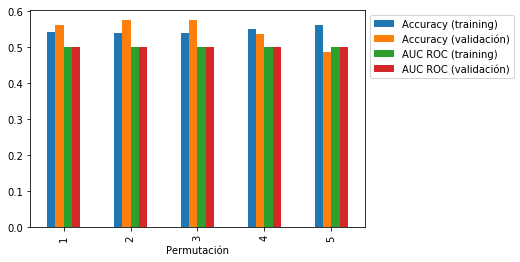

In [7]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

import my_arbol as my_tree

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score


kf = KFold(n_splits=5)

accuracy_train = []
accuracy_eval = []
AUCROC_train = []
AUCROC_eval = []

for dev_index, eval_index in kf.split(X_dev):
    X_dev_folds = X_dev_np[dev_index]
    X_eval_folds = X_dev_np[eval_index]
    y_dev_folds, y_eval_folds = y_dev_np[dev_index], y_dev_np[eval_index]
    
    tree = clf = my_tree.MiClasificadorArbol(list(X.columns))
    tree.fit(X_dev_folds, y_dev_folds)
    
    prediction_dev = tree.predict(X_dev_folds)
    prediction_eval = tree.predict(X_eval_folds)
    
    accuracy_train.append(accuracy_score(y_dev_folds, prediction_dev))
    accuracy_eval.append(accuracy_score(y_eval_folds, prediction_eval))
    AUCROC_train.append(roc_auc_score(y_dev_folds, prediction_dev))
    AUCROC_eval.append(roc_auc_score(y_eval_folds, prediction_eval))
    
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
#########################################################

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracy_train    # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracy_eval   # cambiar por accuracies_validation
df["AUC ROC (training)"] = AUCROC_train      # cambiar por aucs_training
df["AUC ROC (validación)"] = AUCROC_eval    # cambiar por aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()


## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [8]:
def top_resultados(grid, top=5, algorithm_name=''):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print(algorithm_name)
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [10]:
X_np = np.array(X_dev)
y_np = np.array(y_dev).ravel()

In [11]:
# KNeighbors Classifier 
parameters_knn = {'n_neighbors': [5, 10, 50], 'weights': ('uniform', 'distance'), 'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']}
knn = KNeighborsClassifier()

# Linear Discriminant Analysis
parameters_lda = {'solver': ['svd', 'lsqr', 'eigen']}
lda = LinearDiscriminantAnalysis()

# Decision Tree Classifier
parameters_tree = {'criterion': ('gini', 'entropy'), 'splitter': ('random', 'best'), 'max_depth': [None, 3, 50, 100, 150]}
tree = DecisionTreeClassifier()

# Gaussian
gaussian = GaussianNB()

# Linear SVM
parameters_svm = {'penalty': ('l2', ), 'loss':('squared_hinge', 'hinge'), 'C':[1, 0.1, 0.01, 0.0001, 0.00001]}
svm = LinearSVC()

In [12]:
clf = GridSearchCV(knn, parameters_knn, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 24, 'KNeighbors Classifier - Grid Search')

n_iter = 10
clf = RandomizedSearchCV(knn, parameters_knn, cv=5, n_iter=n_iter)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'KNeighbors Classifier - Randomized Search')


KNeighbors Classifier - Grid Search
Top 24 combinaciones


algorithm  n_neighbors   weights  mean_score_validation  \
23       auto           50  distance                 0.7625   
22       auto           50   uniform                 0.7625   
16      brute           50   uniform                 0.7625   
11    kd_tree           50  distance                 0.7625   
10    kd_tree           50   uniform                 0.7625   
..        ...          ...       ...                    ...   
13      brute            5  distance                 0.7175   
1   ball_tree            5  distance                 0.7175   
7     kd_tree            5  distance                 0.7175   
6     kd_tree            5   uniform                 0.7175   
12      brute            5   uniform                 0.7175   

    mean_score_training  
23               1.0000  
22               0.7800  
16               0.7800  
11               1.0000  
10               0.7800  
..                  ...  
13               1.0000  
1                1.0000  
7                1.0000  
6                0.8325  
12               0.8325  

[24 rows x 5 columns]

KNeighbors Classifier - Randomized Search
Top 10 combinaciones


algorithm  n_neighbors   weights  mean_score_validation  \
1    kd_tree           50   uniform                 0.7625   
2  ball_tree           50   uniform                 0.7625   
5    kd_tree           10   uniform                 0.7475   
7      brute           10   uniform                 0.7475   
6  ball_tree           10  distance                 0.7375   
0    kd_tree            5  distance                 0.7175   
3  ball_tree            5  distance                 0.7175   
4       auto            5  distance                 0.7175   
8      brute            5  distance                 0.7175   
9       auto            5   uniform                 0.7175   

   mean_score_training  
1               0.7800  
2               0.7800  
5               0.8069  
7               0.8069  
6               1.0000  
0               1.0000  
3               1.0000  
4               1.0000  
8               1.0000  
9               0.8325

In [13]:
clf = GridSearchCV(lda, parameters_lda, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 3, 'Linear Discriminant Analysis - Grid Search')

n_iter = 1
clf = RandomizedSearchCV(lda, parameters_lda, n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Linear Discriminant Analysis - Randomized Search')

/Users/marialaraa/.virtualenvs/aa/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:294: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  self.coef_ = linalg.lstsq(self.covariance_, self.means_.T)[0].T


Linear Discriminant Analysis - Grid Search
Top 3 combinaciones


solver  mean_score_validation  mean_score_training
2  eigen                 0.6925               0.9513
0    svd                 0.6800               0.9794
1   lsqr                 0.6800               0.9794

Linear Discriminant Analysis - Randomized Search
Top 1 combinaciones


solver  mean_score_validation  mean_score_training
0    svd                   0.68               0.9794

In [14]:
clf = GridSearchCV(tree, parameters_tree, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 20, 'Decision Tree Classifier - Grid Search')

n_iter = 8
clf = RandomizedSearchCV(tree, parameters_tree, n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Decision Tree Classifier - Randomized Search')

Decision Tree Classifier - Grid Search
Top 20 combinaciones


criterion  max_depth splitter  mean_score_validation  mean_score_training
2       gini        3.0   random                 0.6950               0.7769
10   entropy        NaN   random                 0.6800               1.0000
8       gini      150.0   random                 0.6725               1.0000
13   entropy        3.0     best                 0.6725               0.8025
0       gini        NaN   random                 0.6650               1.0000
..       ...        ...      ...                    ...                  ...
1       gini        NaN     best                 0.6275               1.0000
5       gini       50.0     best                 0.6250               1.0000
9       gini      150.0     best                 0.6250               1.0000
7       gini      100.0     best                 0.6225               1.0000
6       gini      100.0   random                 0.6125               1.0000

[20 rows x 5 columns]

Decision Tree Classifier - Randomized Search
Top 8 combinaciones


criterion  max_depth splitter  mean_score_validation  mean_score_training
1      gini        3.0   random                 0.7100               0.7732
4   entropy        3.0     best                 0.6700               0.8025
5   entropy        NaN     best                 0.6575               1.0000
3      gini      100.0   random                 0.6525               1.0000
0   entropy      100.0     best                 0.6325               1.0000
6      gini      150.0   random                 0.6325               1.0000
7   entropy        NaN   random                 0.6275               1.0000
2      gini      100.0     best                 0.5900               1.0000

In [15]:
clf.fit(X_np, y_np)
top_resultados(clf, 1, 'Gaussian')

Gaussian
Top 1 combinaciones


criterion  max_depth splitter  mean_score_validation  mean_score_training
4   entropy        3.0     best                   0.67               0.8025

In [16]:
clf = GridSearchCV(svm, parameters_svm, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 10, 'Linear SVM - Grid Search')

n_iter = 5
clf = RandomizedSearchCV(svm, parameters_svm, n_iter, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, n_iter, 'Linear SVM - Randomized Search')

Linear SVM - Grid Search
Top 10 combinaciones


C           loss penalty  mean_score_validation  \
4  1.0000e-02  squared_hinge      l2                 0.7575   
5  1.0000e-02          hinge      l2                 0.7525   
2  1.0000e-01  squared_hinge      l2                 0.7400   
3  1.0000e-01          hinge      l2                 0.7400   
6  1.0000e-04  squared_hinge      l2                 0.7400   
0  1.0000e+00  squared_hinge      l2                 0.7375   
1  1.0000e+00          hinge      l2                 0.7375   
8  1.0000e-05  squared_hinge      l2                 0.7250   
7  1.0000e-04          hinge      l2                 0.7225   
9  1.0000e-05          hinge      l2                 0.7225   

   mean_score_training  
4               0.9813  
5               0.9263  
2               1.0000  
3               0.9969  
6               0.8000  
0               1.0000  
1               1.0000  
8               0.7631  
7               0.7563  
9               0.7556

Linear SVM - Randomized Search
Top 5 combinaciones


C           loss penalty  mean_score_validation  \
1  1.0000e-02          hinge      l2                 0.7525   
0  1.0000e-01  squared_hinge      l2                 0.7400   
3  1.0000e-04  squared_hinge      l2                 0.7400   
2  1.0000e-04          hinge      l2                 0.7225   
4  1.0000e-05          hinge      l2                 0.7225   

   mean_score_training  
1               0.9263  
0               1.0000  
3               0.8000  
2               0.7563  
4               0.7556

#### Conclusiones Grid Search

< < COMPLETAR > > <--- Bruno

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




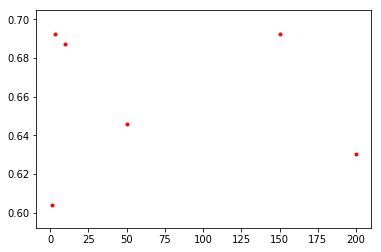

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
max_depths = [1, 3, 10, 50, 150, 200]
auc_roc = []

for max_depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_train_np, y_train_np)
        
    prediction_eval = tree.predict(X_test_np)
    auc_roc.append(roc_auc_score(y_test_np, prediction_eval))


fig = plt.scatter(max_depths, auc_roc , marker=".", color="red")

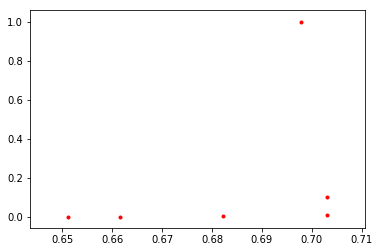

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
auc_roc = []

for C in Cs:
    svm = LinearSVC(C=C)
    svm.fit(X_train_np, y_train_np)
        
    prediction_eval = svm.predict(X_test_np)
    auc_roc.append(roc_auc_score(y_test_np, prediction_eval))


fig = plt.scatter(auc_roc, Cs, marker=".", color="red")

In [19]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

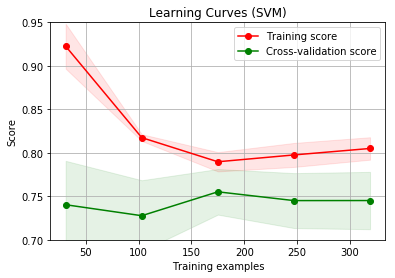

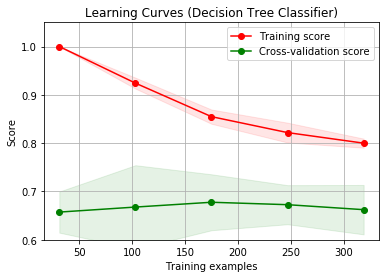

In [20]:
title = "Learning Curves (SVM)"
estimator = LinearSVC(C=0.0001)
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, ylim=(0.7, 0.95), cv=5, n_jobs=4)

title = "Learning Curves (Decision Tree Classifier)"
estimator = DecisionTreeClassifier(max_depth=3, criterion='entropy', splitter='best')
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, (0.6, 1.05), cv=5, n_jobs=4)

plt.show()

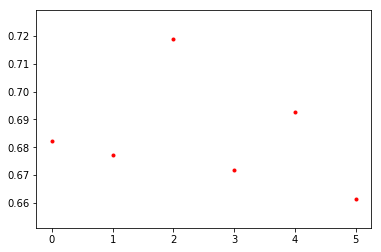

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
max_features = [5, 50, 100, 183, 'auto', 'log2']
auc_roc = []

for max_feature in max_features :
    random_forest = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=3, max_features=max_feature)
    random_forest.fit(X_train_np, y_train_np)
        
    prediction_eval = random_forest.predict(X_test_np)
    score = roc_auc_score(y_test_np, prediction_eval)
    auc_roc.append(score)


fig = plt.scatter(range(len(max_features)), auc_roc, marker=".", color="red")

Nos quedamos solo con arboles de profundidad tres. Mayor profundidad overfittea. 

In [ ]:
# Random Forest Classifier
parameters_rf = {'n_estimators':(200,), 'criterion': ('gini', 'entropy'), 'max_depth': [3], 'max_features':[5, 50, 100, 183, 'auto', 'log2']}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters_rf, cv=5)
clf.fit(X_np, y_np)
top_resultados(clf, 10, 'Random Forest Classifier - Grid Search')



In [ ]:
title = "Learning Curves (Random Forest)"
estimator = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='auto', n_estimators=200)
plot_learning_curve(estimator, title, X_dev_np, y_dev_np, ylim=(0.7, 1.05), cv=5, n_jobs=4)


plt.show()

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
